In [2]:
import os
import gc
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19"))

***
# Level 1

In [5]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )
data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)

data.sort_values(["ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

scale_factor = np.sqrt(np.nanmean(data.y.diff(1)**2))
scale_factor

remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

***

In [6]:
model_params = {
    'objective': 'l2', 
    'metric': 'rmse', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'learning_rate': 0.28543912663785515, 
    'num_leaves': 10, 
    'max_bin': 123, 
    'feature_fraction': 0.7000000000000001, 
    'bagging_fraction': 0.8, 
    'min_data_in_leaf': 5, 
    'min_gain_to_split': 100000, 
    'lambda_l2': 0.6845940785471598, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{"event_name_1":"default"},
    "copy":True,
}

In [7]:
# 4+ years of history
train_history = 1800

############################################### 1/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1006.07it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2532.37
[50]	valid_0's rmse: 2439.75
[75]	valid_0's rmse: 2275.88
[100]	valid_0's rmse: 2300.04
[125]	valid_0's rmse: 2249.08
[150]	valid_0's rmse: 2246.48
[175]	valid_0's rmse: 2222.88
[200]	valid_0's rmse: 2209.72
[225]	valid_0's rmse: 2170.75
[250]	valid_0's rmse: 2160.21
[275]	valid_0's rmse: 2142.04
[300]	valid_0's rmse: 2133.19
[325]	valid_0's rmse: 2118.86
[350]	valid_0's rmse: 2117.75
[375]	valid_0's rmse: 2103.21
[400]	valid_0's rmse: 2115.63
[425]	valid_0's rmse: 2129.36
[450]	valid_0's rmse: 2128.41
[475]	valid_0's rmse: 2138.73
[500]	valid_0's rmse: 2140.29
[525]	valid_0's rmse: 2126.65
[550]	valid_0's rmse: 2144.85
[575]	valid_0's rmse: 2147.73
[600]	valid_0's rmse: 2154.1
[625]	valid_0's rmse: 2154.91
[650]	valid_0's rmse: 2140.92
Early stopping, best iteration is:
[374]	valid_0's rmse: 2103.18
RMSE: 2103.1766123069015
RMSSE: 0.35490585567530475


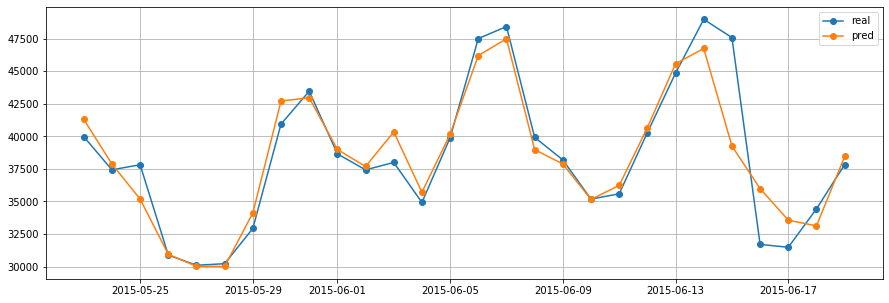

############################################### 2/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2172.09it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2387.99
[50]	valid_0's rmse: 2326.64
[75]	valid_0's rmse: 2198.43
[100]	valid_0's rmse: 2189.92
[125]	valid_0's rmse: 2193.94
[150]	valid_0's rmse: 2162.6
[175]	valid_0's rmse: 2189.25
[200]	valid_0's rmse: 2143.79
[225]	valid_0's rmse: 2129.1
[250]	valid_0's rmse: 2146.23
[275]	valid_0's rmse: 2133.25
[300]	valid_0's rmse: 2173.88
[325]	valid_0's rmse: 2188.97
[350]	valid_0's rmse: 2196.31
[375]	valid_0's rmse: 2201.29
[400]	valid_0's rmse: 2203.26
[425]	valid_0's rmse: 2186.85
[450]	valid_0's rmse: 2180.49
[475]	valid_0's rmse: 2183.92
[500]	valid_0's rmse: 2188.01
Early stopping, best iteration is:
[201]	valid_0's rmse: 2124.84
RMSE: 2124.8374853716086
RMSSE: 0.358561074473726


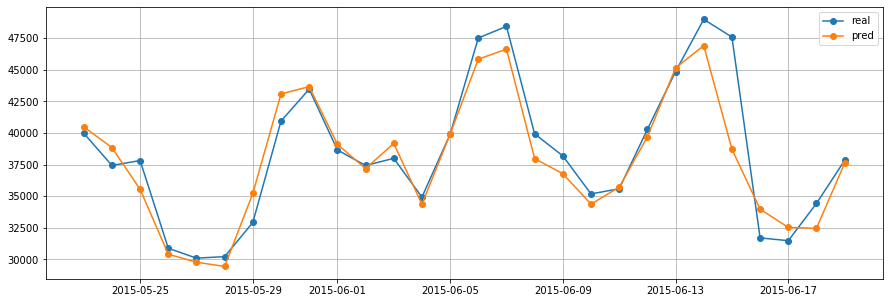

############################################### 3/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1642.89it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2328.34
[50]	valid_0's rmse: 2207.38
[75]	valid_0's rmse: 2131.18
[100]	valid_0's rmse: 2114.12
[125]	valid_0's rmse: 2131.56
[150]	valid_0's rmse: 2117.31
[175]	valid_0's rmse: 2079.48
[200]	valid_0's rmse: 2067.33
[225]	valid_0's rmse: 2057.12
[250]	valid_0's rmse: 2073.3
[275]	valid_0's rmse: 2078.91
[300]	valid_0's rmse: 2106.11
[325]	valid_0's rmse: 2118.9
[350]	valid_0's rmse: 2131.54
[375]	valid_0's rmse: 2109.87
[400]	valid_0's rmse: 2100.03
[425]	valid_0's rmse: 2113.57
[450]	valid_0's rmse: 2087.46
[475]	valid_0's rmse: 2093.18
[500]	valid_0's rmse: 2084.74
[525]	valid_0's rmse: 2063.31
Early stopping, best iteration is:
[225]	valid_0's rmse: 2057.12
RMSE: 2057.119475723934
RMSSE: 0.3471338276994882


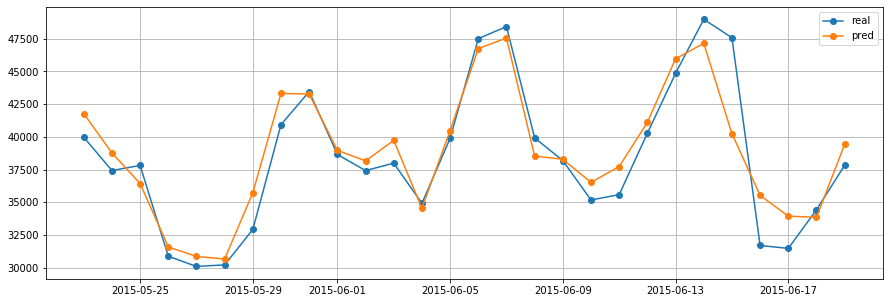

############################################### 4/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 742.09it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2487.26
[50]	valid_0's rmse: 2375.23
[75]	valid_0's rmse: 2337.14
[100]	valid_0's rmse: 2276.3
[125]	valid_0's rmse: 2183.66
[150]	valid_0's rmse: 2212.2
[175]	valid_0's rmse: 2225.83
[200]	valid_0's rmse: 2196.36
[225]	valid_0's rmse: 2201.02
[250]	valid_0's rmse: 2214.21
[275]	valid_0's rmse: 2240.83
[300]	valid_0's rmse: 2221.76
[325]	valid_0's rmse: 2218.21
[350]	valid_0's rmse: 2204.91
[375]	valid_0's rmse: 2180.8
[400]	valid_0's rmse: 2180.16
[425]	valid_0's rmse: 2165.54
[450]	valid_0's rmse: 2150.05
[475]	valid_0's rmse: 2160.85
[500]	valid_0's rmse: 2182.9
[525]	valid_0's rmse: 2184.93
[550]	valid_0's rmse: 2153.81
[575]	valid_0's rmse: 2147.71
[600]	valid_0's rmse: 2155.93
[625]	valid_0's rmse: 2156.75
[650]	valid_0's rmse: 2164.19
[675]	valid_0's rmse: 2152.69
[700]	valid_0's rmse: 2154.37
[725]	valid_0's rmse: 2143.28
[750]	valid_0's rmse: 2148.52
[775]	valid_0's rmse: 2148.94
[800]	valid_0's

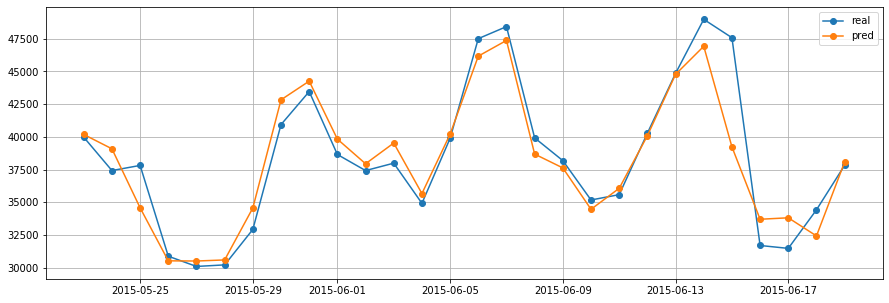

############################################### 5/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1635.84it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2410.32
[50]	valid_0's rmse: 2272.32
[75]	valid_0's rmse: 2156.69
[100]	valid_0's rmse: 2212.19
[125]	valid_0's rmse: 2231.16
[150]	valid_0's rmse: 2214.82
[175]	valid_0's rmse: 2196.48
[200]	valid_0's rmse: 2153.7
[225]	valid_0's rmse: 2169.08
[250]	valid_0's rmse: 2137.95
[275]	valid_0's rmse: 2119.64
[300]	valid_0's rmse: 2117.45
[325]	valid_0's rmse: 2117.65
[350]	valid_0's rmse: 2058.12
[375]	valid_0's rmse: 2067.94
[400]	valid_0's rmse: 2019.13
[425]	valid_0's rmse: 2015.27
[450]	valid_0's rmse: 2034.48
[475]	valid_0's rmse: 2030.89
[500]	valid_0's rmse: 2056.32
[525]	valid_0's rmse: 2019.11
[550]	valid_0's rmse: 2017.38
[575]	valid_0's rmse: 2016.6
[600]	valid_0's rmse: 2050.01
[625]	valid_0's rmse: 2061.07
[650]	valid_0's rmse: 2047.68
[675]	valid_0's rmse: 2064.87
Early stopping, best iteration is:
[383]	valid_0's rmse: 2001.11
RMSE: 2001.1090283035874
RMSSE: 0.3376822031178175


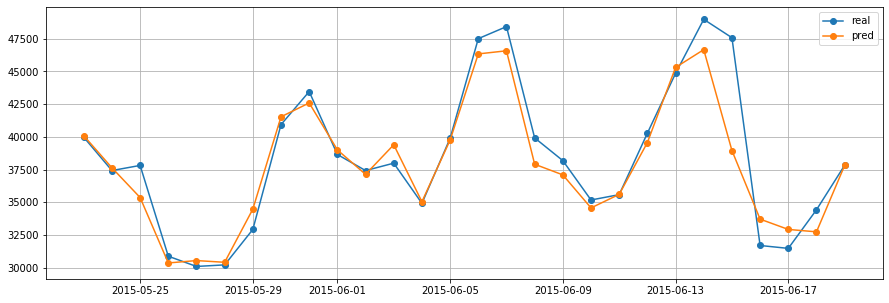

############################################### 6/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1760.83it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2489.03
[50]	valid_0's rmse: 2406.14
[75]	valid_0's rmse: 2290.07
[100]	valid_0's rmse: 2226.51
[125]	valid_0's rmse: 2177.31
[150]	valid_0's rmse: 2188.93
[175]	valid_0's rmse: 2167.25
[200]	valid_0's rmse: 2169.71
[225]	valid_0's rmse: 2169.45
[250]	valid_0's rmse: 2160.9
[275]	valid_0's rmse: 2136.17
[300]	valid_0's rmse: 2105.02
[325]	valid_0's rmse: 2073.12
[350]	valid_0's rmse: 2061.89
[375]	valid_0's rmse: 2075.03
[400]	valid_0's rmse: 2064.77
[425]	valid_0's rmse: 2079.33
[450]	valid_0's rmse: 2086.85
[475]	valid_0's rmse: 2096.08
[500]	valid_0's rmse: 2106.67
[525]	valid_0's rmse: 2110.79
[550]	valid_0's rmse: 2110.37
[575]	valid_0's rmse: 2127.41
[600]	valid_0's rmse: 2106.81
[625]	valid_0's rmse: 2099.78
[650]	valid_0's rmse: 2109.87
Early stopping, best iteration is:
[354]	valid_0's rmse: 2057.26
RMSE: 2057.2600803771725
RMSSE: 0.3471575543872411


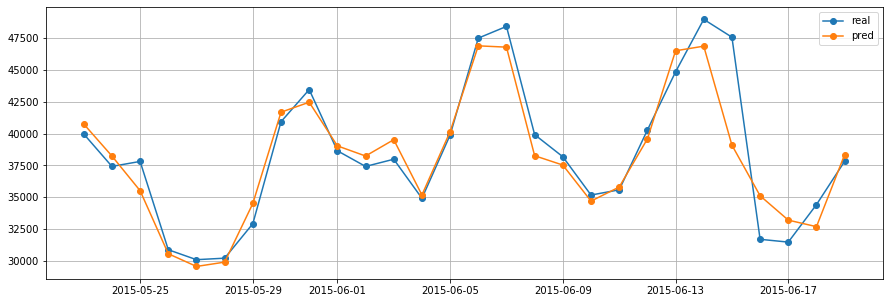

############################################### 7/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1741.10it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2585.14
[50]	valid_0's rmse: 2339.91
[75]	valid_0's rmse: 2273.52
[100]	valid_0's rmse: 2252.2
[125]	valid_0's rmse: 2204.69
[150]	valid_0's rmse: 2193.01
[175]	valid_0's rmse: 2167.4
[200]	valid_0's rmse: 2149.23
[225]	valid_0's rmse: 2127.09
[250]	valid_0's rmse: 2104.51
[275]	valid_0's rmse: 2110.91
[300]	valid_0's rmse: 2113.82
[325]	valid_0's rmse: 2080.13
[350]	valid_0's rmse: 2053.54
[375]	valid_0's rmse: 2045.12
[400]	valid_0's rmse: 2038.63
[425]	valid_0's rmse: 2052.06
[450]	valid_0's rmse: 2054.62
[475]	valid_0's rmse: 2049.48
[500]	valid_0's rmse: 2040.06
[525]	valid_0's rmse: 2025.36
[550]	valid_0's rmse: 2008.65
[575]	valid_0's rmse: 2010.9
[600]	valid_0's rmse: 2022.05
[625]	valid_0's rmse: 2022.22
[650]	valid_0's rmse: 2023.54
[675]	valid_0's rmse: 2035.79
[700]	valid_0's rmse: 2043.24
[725]	valid_0's rmse: 2030.84
[750]	valid_0's rmse: 2041.22
[775]	valid_0's rmse: 2040.12
[800]	valid_0'

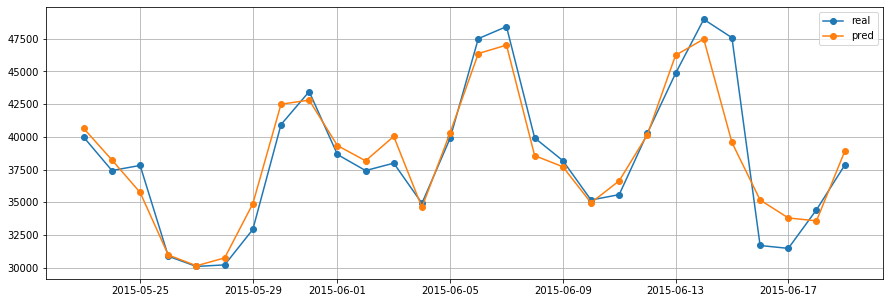

############################################### 8/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2081.54it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2482.8
[50]	valid_0's rmse: 2348.32
[75]	valid_0's rmse: 2313.12
[100]	valid_0's rmse: 2326.92
[125]	valid_0's rmse: 2329.57
[150]	valid_0's rmse: 2344.54
[175]	valid_0's rmse: 2333.66
[200]	valid_0's rmse: 2319.22
[225]	valid_0's rmse: 2383.83
[250]	valid_0's rmse: 2402.67
[275]	valid_0's rmse: 2401.66
[300]	valid_0's rmse: 2366.63
[325]	valid_0's rmse: 2319.02
[350]	valid_0's rmse: 2297.82
[375]	valid_0's rmse: 2309.96
[400]	valid_0's rmse: 2307.93
[425]	valid_0's rmse: 2303.66
[450]	valid_0's rmse: 2311.52
[475]	valid_0's rmse: 2307.82
[500]	valid_0's rmse: 2284.11
[525]	valid_0's rmse: 2289.6
[550]	valid_0's rmse: 2293.38
[575]	valid_0's rmse: 2276.67
[600]	valid_0's rmse: 2297.62
[625]	valid_0's rmse: 2279.5
[650]	valid_0's rmse: 2268.21
[675]	valid_0's rmse: 2263.6
[700]	valid_0's rmse: 2251.26
[725]	valid_0's rmse: 2255.01
[750]	valid_0's rmse: 2238.9
[775]	valid_0's rmse: 2251.63
[800]	valid_0's 

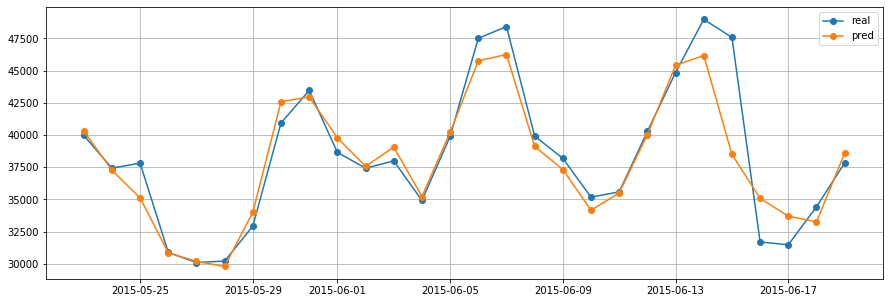

############################################### 9/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1635.84it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2479.62
[50]	valid_0's rmse: 2350.64
[75]	valid_0's rmse: 2255
[100]	valid_0's rmse: 2273.35
[125]	valid_0's rmse: 2289.16
[150]	valid_0's rmse: 2251.09
[175]	valid_0's rmse: 2250.43
[200]	valid_0's rmse: 2262.26
[225]	valid_0's rmse: 2276.64
[250]	valid_0's rmse: 2279.51
[275]	valid_0's rmse: 2292.12
[300]	valid_0's rmse: 2289.94
[325]	valid_0's rmse: 2251.32
[350]	valid_0's rmse: 2237.81
[375]	valid_0's rmse: 2188.84
[400]	valid_0's rmse: 2180.86
[425]	valid_0's rmse: 2181.2
[450]	valid_0's rmse: 2164.47
[475]	valid_0's rmse: 2157.38
[500]	valid_0's rmse: 2162.41
[525]	valid_0's rmse: 2138.29
[550]	valid_0's rmse: 2152.78
[575]	valid_0's rmse: 2170.09
[600]	valid_0's rmse: 2187.49
[625]	valid_0's rmse: 2186.37
[650]	valid_0's rmse: 2175.19
[675]	valid_0's rmse: 2177.38
[700]	valid_0's rmse: 2146.18
[725]	valid_0's rmse: 2128.7
[750]	valid_0's rmse: 2127.15
[775]	valid_0's rmse: 2130.16
[800]	valid_0's 

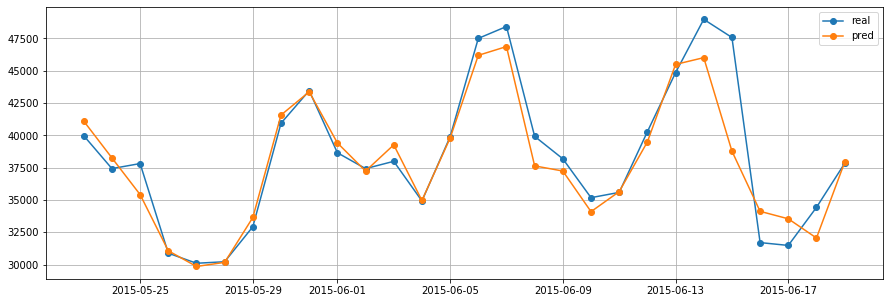

############################################## 10/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2032.12it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2518.68
[50]	valid_0's rmse: 2337.01
[75]	valid_0's rmse: 2300.56
[100]	valid_0's rmse: 2282.77
[125]	valid_0's rmse: 2245.76
[150]	valid_0's rmse: 2198.11
[175]	valid_0's rmse: 2161.66
[200]	valid_0's rmse: 2156.47
[225]	valid_0's rmse: 2143.15
[250]	valid_0's rmse: 2115.46
[275]	valid_0's rmse: 2107.69
[300]	valid_0's rmse: 2080.66
[325]	valid_0's rmse: 2098.1
[350]	valid_0's rmse: 2083.37
[375]	valid_0's rmse: 2074.75
[400]	valid_0's rmse: 2073.66
[425]	valid_0's rmse: 2074.78
[450]	valid_0's rmse: 2071.75
[475]	valid_0's rmse: 2059.15
[500]	valid_0's rmse: 2072.96
[525]	valid_0's rmse: 2070.93
[550]	valid_0's rmse: 2078.02
[575]	valid_0's rmse: 2077.24
[600]	valid_0's rmse: 2059.11
[625]	valid_0's rmse: 2055.3
[650]	valid_0's rmse: 2061.73
[675]	valid_0's rmse: 2044.9
[700]	valid_0's rmse: 2053.2
[725]	valid_0's rmse: 2061.42
[750]	valid_0's rmse: 2041.23
[775]	valid_0's rmse: 2038.46
[800]	valid_0's

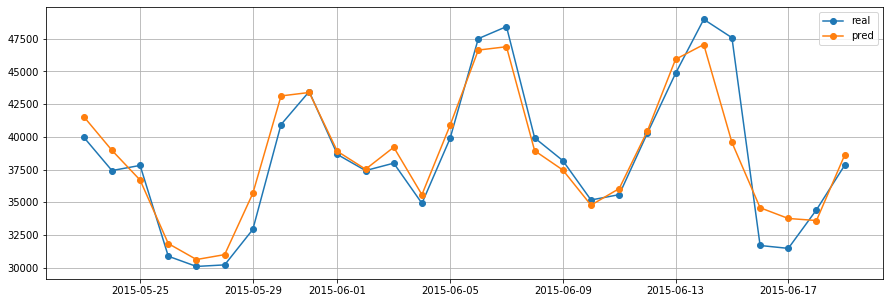

############################################## 11/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1168.66it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2480.59
[50]	valid_0's rmse: 2280.07
[75]	valid_0's rmse: 2182.92
[100]	valid_0's rmse: 2140.2
[125]	valid_0's rmse: 2162.8
[150]	valid_0's rmse: 2181.29
[175]	valid_0's rmse: 2131.53
[200]	valid_0's rmse: 2163.58
[225]	valid_0's rmse: 2142.27
[250]	valid_0's rmse: 2167.03
[275]	valid_0's rmse: 2156.35
[300]	valid_0's rmse: 2160.05
[325]	valid_0's rmse: 2166.79
[350]	valid_0's rmse: 2192.88
[375]	valid_0's rmse: 2190.77
[400]	valid_0's rmse: 2203.04
[425]	valid_0's rmse: 2206.51
[450]	valid_0's rmse: 2194.31
[475]	valid_0's rmse: 2189.31
Early stopping, best iteration is:
[181]	valid_0's rmse: 2125.1
RMSE: 2125.0994186077105
RMSSE: 0.35860527505999373


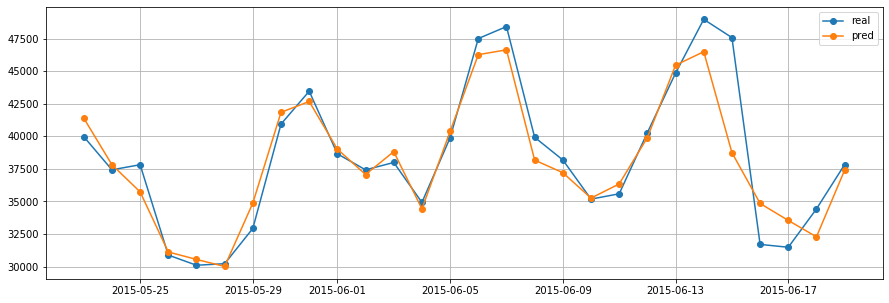

############################################## 12/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1464.49it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2379.53
[50]	valid_0's rmse: 2280.67
[75]	valid_0's rmse: 2135.74
[100]	valid_0's rmse: 2077.98
[125]	valid_0's rmse: 2042.87
[150]	valid_0's rmse: 2016.7
[175]	valid_0's rmse: 2008.01
[200]	valid_0's rmse: 2023.6
[225]	valid_0's rmse: 1992.52
[250]	valid_0's rmse: 1996.15
[275]	valid_0's rmse: 1946.97
[300]	valid_0's rmse: 1941.93
[325]	valid_0's rmse: 1928.56
[350]	valid_0's rmse: 1926.29
[375]	valid_0's rmse: 1910.99
[400]	valid_0's rmse: 1906.24
[425]	valid_0's rmse: 1920.74
[450]	valid_0's rmse: 1933.23
[475]	valid_0's rmse: 1932.24
[500]	valid_0's rmse: 1934.15
[525]	valid_0's rmse: 1932.13
[550]	valid_0's rmse: 1900.28
[575]	valid_0's rmse: 1881.43
[600]	valid_0's rmse: 1887.43
[625]	valid_0's rmse: 1884.25
[650]	valid_0's rmse: 1883.79
[675]	valid_0's rmse: 1862.55
[700]	valid_0's rmse: 1867.28
[725]	valid_0's rmse: 1878.78
[750]	valid_0's rmse: 1882.89
[775]	valid_0's rmse: 1872.67
[800]	valid_0

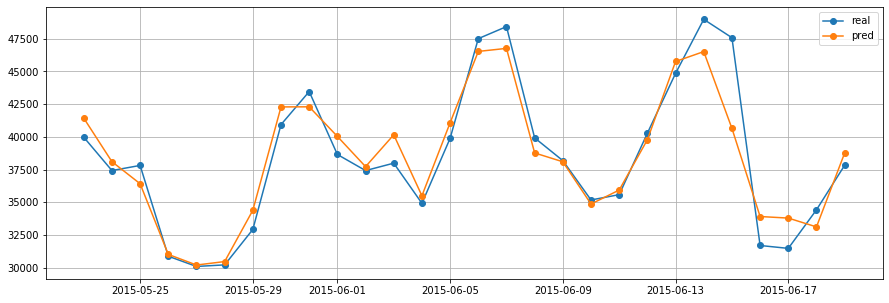

############################################## 13/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1397.64it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2379.65
[50]	valid_0's rmse: 2301.59
[75]	valid_0's rmse: 2294.98
[100]	valid_0's rmse: 2235.86
[125]	valid_0's rmse: 2213.92
[150]	valid_0's rmse: 2180.87
[175]	valid_0's rmse: 2175.22
[200]	valid_0's rmse: 2176.29
[225]	valid_0's rmse: 2165.3
[250]	valid_0's rmse: 2163.83
[275]	valid_0's rmse: 2145.9
[300]	valid_0's rmse: 2159.4
[325]	valid_0's rmse: 2169.65
[350]	valid_0's rmse: 2092.47
[375]	valid_0's rmse: 2060.34
[400]	valid_0's rmse: 2065.57
[425]	valid_0's rmse: 2067.18
[450]	valid_0's rmse: 2063.09
[475]	valid_0's rmse: 2087.51
[500]	valid_0's rmse: 2074.4
[525]	valid_0's rmse: 2061.68
[550]	valid_0's rmse: 2074.05
[575]	valid_0's rmse: 2069.1
[600]	valid_0's rmse: 2084.51
[625]	valid_0's rmse: 2081.45
[650]	valid_0's rmse: 2095.13
[675]	valid_0's rmse: 2105.95
Early stopping, best iteration is:
[397]	valid_0's rmse: 2055.9
RMSE: 2055.895649984551
RMSSE: 0.3469273101304492


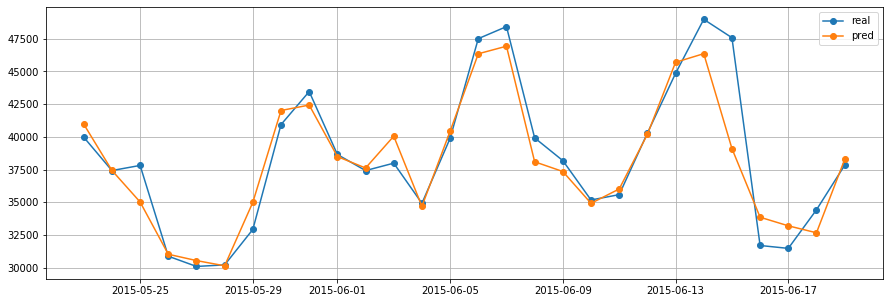

############################################## 14/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1754.94it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2545.36
[50]	valid_0's rmse: 2240.59
[75]	valid_0's rmse: 2136.05
[100]	valid_0's rmse: 2124.19
[125]	valid_0's rmse: 2075.67
[150]	valid_0's rmse: 2008.4
[175]	valid_0's rmse: 2003.32
[200]	valid_0's rmse: 2031.65
[225]	valid_0's rmse: 2023.86
[250]	valid_0's rmse: 2031.11
[275]	valid_0's rmse: 2029.81
[300]	valid_0's rmse: 2023.02
[325]	valid_0's rmse: 2016.75
[350]	valid_0's rmse: 2007.49
[375]	valid_0's rmse: 1992.12
[400]	valid_0's rmse: 2003.09
[425]	valid_0's rmse: 2004.58
[450]	valid_0's rmse: 1998.67
[475]	valid_0's rmse: 2004.21
[500]	valid_0's rmse: 2001.31
[525]	valid_0's rmse: 1995.51
[550]	valid_0's rmse: 1983.04
[575]	valid_0's rmse: 1981.52
[600]	valid_0's rmse: 1979.18
[625]	valid_0's rmse: 1982.07
[650]	valid_0's rmse: 1991.62
[675]	valid_0's rmse: 1999.92
[700]	valid_0's rmse: 1985.71
[725]	valid_0's rmse: 1993.68
[750]	valid_0's rmse: 1979.17
[775]	valid_0's rmse: 1975.2
[800]	valid_0

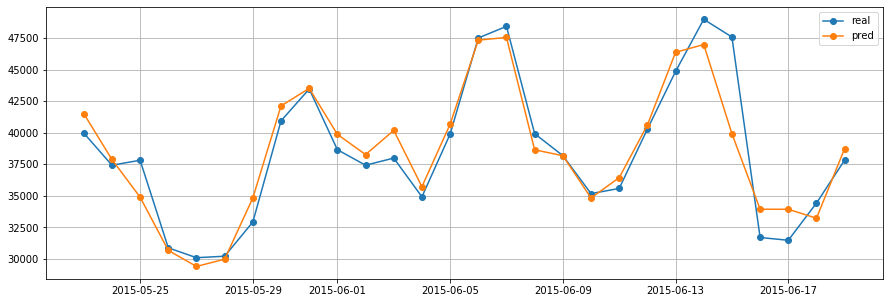

############################################## 15/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1628.86it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2580.13
[50]	valid_0's rmse: 2536.91
[75]	valid_0's rmse: 2404.87
[100]	valid_0's rmse: 2390.18
[125]	valid_0's rmse: 2347.86
[150]	valid_0's rmse: 2330.94
[175]	valid_0's rmse: 2312.01
[200]	valid_0's rmse: 2303.46
[225]	valid_0's rmse: 2311.61
[250]	valid_0's rmse: 2303.32
[275]	valid_0's rmse: 2335.5
[300]	valid_0's rmse: 2327.02
[325]	valid_0's rmse: 2292.99
[350]	valid_0's rmse: 2278.17
[375]	valid_0's rmse: 2277.65
[400]	valid_0's rmse: 2261.1
[425]	valid_0's rmse: 2259.87
[450]	valid_0's rmse: 2277
[475]	valid_0's rmse: 2240.52
[500]	valid_0's rmse: 2239.86
[525]	valid_0's rmse: 2228.01
[550]	valid_0's rmse: 2209.12
[575]	valid_0's rmse: 2210.74
[600]	valid_0's rmse: 2200.14
[625]	valid_0's rmse: 2206.14
[650]	valid_0's rmse: 2224.15
[675]	valid_0's rmse: 2206.64
[700]	valid_0's rmse: 2223.22
[725]	valid_0's rmse: 2207.5
[750]	valid_0's rmse: 2233.55
[775]	valid_0's rmse: 2239.58
[800]	valid_0's r

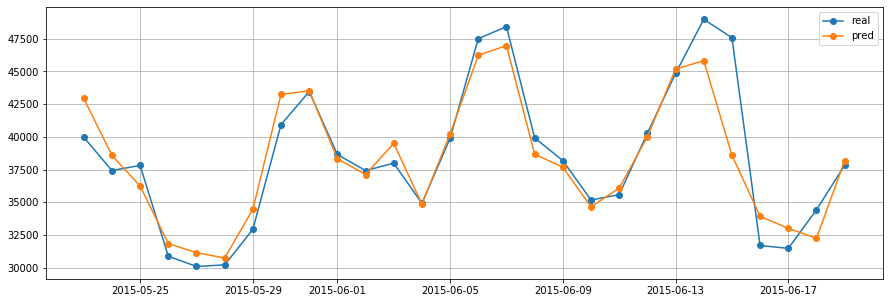

############################################## 16/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1880.01it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2577.23
[50]	valid_0's rmse: 2455.79
[75]	valid_0's rmse: 2444.8
[100]	valid_0's rmse: 2373.47
[125]	valid_0's rmse: 2342.68
[150]	valid_0's rmse: 2307.62
[175]	valid_0's rmse: 2314.74
[200]	valid_0's rmse: 2232.67
[225]	valid_0's rmse: 2260.15
[250]	valid_0's rmse: 2258.49
[275]	valid_0's rmse: 2265.54
[300]	valid_0's rmse: 2274.32
[325]	valid_0's rmse: 2208.58
[350]	valid_0's rmse: 2196.85
[375]	valid_0's rmse: 2196.36
[400]	valid_0's rmse: 2185.78
[425]	valid_0's rmse: 2184.42
[450]	valid_0's rmse: 2197.51
[475]	valid_0's rmse: 2195.62
[500]	valid_0's rmse: 2182.7
[525]	valid_0's rmse: 2189.31
[550]	valid_0's rmse: 2181.09
[575]	valid_0's rmse: 2183.73
[600]	valid_0's rmse: 2176.43
[625]	valid_0's rmse: 2169.92
[650]	valid_0's rmse: 2207.28
[675]	valid_0's rmse: 2205.45
[700]	valid_0's rmse: 2204.38
[725]	valid_0's rmse: 2213.94
[750]	valid_0's rmse: 2232.78
[775]	valid_0's rmse: 2211.24
[800]	valid_0

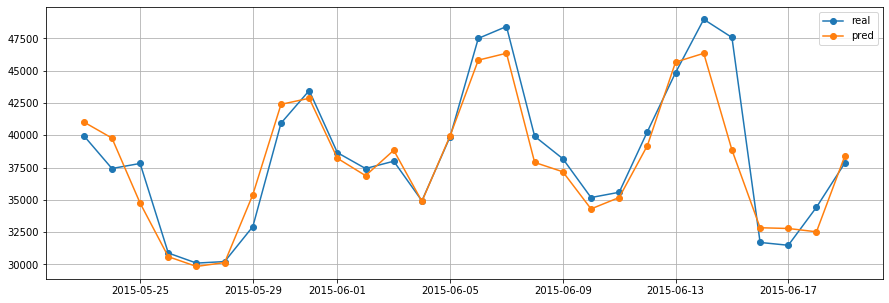

############################################## 17/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2024.28it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2521.91
[50]	valid_0's rmse: 2402.32
[75]	valid_0's rmse: 2329.53
[100]	valid_0's rmse: 2297.04
[125]	valid_0's rmse: 2293.69
[150]	valid_0's rmse: 2249.86
[175]	valid_0's rmse: 2259.45
[200]	valid_0's rmse: 2259.33
[225]	valid_0's rmse: 2228.19
[250]	valid_0's rmse: 2222.19
[275]	valid_0's rmse: 2195.91
[300]	valid_0's rmse: 2182.48
[325]	valid_0's rmse: 2176.93
[350]	valid_0's rmse: 2169.31
[375]	valid_0's rmse: 2166.78
[400]	valid_0's rmse: 2172.3
[425]	valid_0's rmse: 2146.82
[450]	valid_0's rmse: 2137.38
[475]	valid_0's rmse: 2122.41
[500]	valid_0's rmse: 2100.49
[525]	valid_0's rmse: 2110.03
[550]	valid_0's rmse: 2102.05
[575]	valid_0's rmse: 2079.37
[600]	valid_0's rmse: 2095.73
[625]	valid_0's rmse: 2106.51
[650]	valid_0's rmse: 2110.82
[675]	valid_0's rmse: 2106.87
[700]	valid_0's rmse: 2107.69
[725]	valid_0's rmse: 2104.95
[750]	valid_0's rmse: 2097.1
[775]	valid_0's rmse: 2093.56
[800]	valid_0

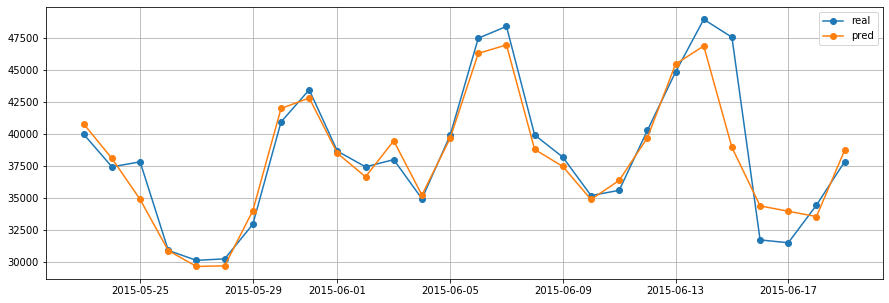

############################################## 18/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 2110.87it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2439.57
[50]	valid_0's rmse: 2212.76
[75]	valid_0's rmse: 2184.32
[100]	valid_0's rmse: 2155.96
[125]	valid_0's rmse: 2154.18
[150]	valid_0's rmse: 2129.56
[175]	valid_0's rmse: 2132.4
[200]	valid_0's rmse: 2111.62
[225]	valid_0's rmse: 2103.42
[250]	valid_0's rmse: 2102.69
[275]	valid_0's rmse: 2089.05
[300]	valid_0's rmse: 2082.26
[325]	valid_0's rmse: 2079.28
[350]	valid_0's rmse: 2091.34
[375]	valid_0's rmse: 2080.11
[400]	valid_0's rmse: 2098.32
[425]	valid_0's rmse: 2087.46
[450]	valid_0's rmse: 2074.12
[475]	valid_0's rmse: 2081.18
[500]	valid_0's rmse: 2086.72
[525]	valid_0's rmse: 2069.1
[550]	valid_0's rmse: 2046.07
[575]	valid_0's rmse: 2062.06
[600]	valid_0's rmse: 2063.94
[625]	valid_0's rmse: 2081.65
[650]	valid_0's rmse: 2079.21
[675]	valid_0's rmse: 2069.7
[700]	valid_0's rmse: 2071.29
[725]	valid_0's rmse: 2066.94
[750]	valid_0's rmse: 2073.73
[775]	valid_0's rmse: 2064.62
[800]	valid_0'

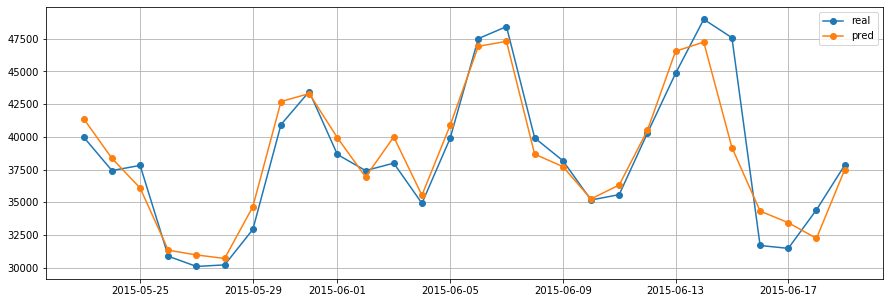

############################################## 19/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1594.19it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2663.57
[50]	valid_0's rmse: 2270.04
[75]	valid_0's rmse: 2263.05
[100]	valid_0's rmse: 2245.84
[125]	valid_0's rmse: 2197.9
[150]	valid_0's rmse: 2121.5
[175]	valid_0's rmse: 2106.71
[200]	valid_0's rmse: 2098.46
[225]	valid_0's rmse: 2052.65
[250]	valid_0's rmse: 2030.1
[275]	valid_0's rmse: 2019.59
[300]	valid_0's rmse: 2029.39
[325]	valid_0's rmse: 1969.57
[350]	valid_0's rmse: 1988.25
[375]	valid_0's rmse: 2008.18
[400]	valid_0's rmse: 2011.73
[425]	valid_0's rmse: 2004.82
[450]	valid_0's rmse: 1999.9
[475]	valid_0's rmse: 1995.3
[500]	valid_0's rmse: 1996.18
[525]	valid_0's rmse: 1991.3
[550]	valid_0's rmse: 1984.89
[575]	valid_0's rmse: 1981.07
[600]	valid_0's rmse: 2001.82
[625]	valid_0's rmse: 2000.14
Early stopping, best iteration is:
[325]	valid_0's rmse: 1969.57
RMSE: 1969.5687967754031
RMSSE: 0.33235986699387715


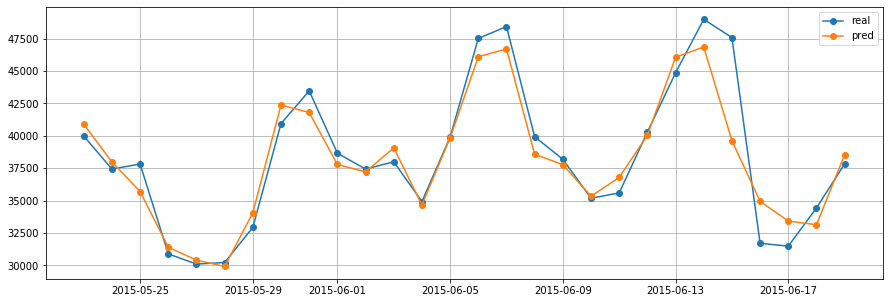

############################################## 20/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 1/1 [00:00<00:00, 1652.60it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's rmse: 2432.65
[50]	valid_0's rmse: 2268.82
[75]	valid_0's rmse: 2175.42
[100]	valid_0's rmse: 2157.69
[125]	valid_0's rmse: 2156.5
[150]	valid_0's rmse: 2196.96
[175]	valid_0's rmse: 2194.38
[200]	valid_0's rmse: 2159.6
[225]	valid_0's rmse: 2176.91
[250]	valid_0's rmse: 2146.71
[275]	valid_0's rmse: 2124.8
[300]	valid_0's rmse: 2150.08
[325]	valid_0's rmse: 2147.83
[350]	valid_0's rmse: 2198.95
[375]	valid_0's rmse: 2198.41
[400]	valid_0's rmse: 2196.76
[425]	valid_0's rmse: 2179.21
[450]	valid_0's rmse: 2197.08
[475]	valid_0's rmse: 2199.88
[500]	valid_0's rmse: 2194.65
[525]	valid_0's rmse: 2182.34
[550]	valid_0's rmse: 2158.74
Early stopping, best iteration is:
[262]	valid_0's rmse: 2121.35
RMSE: 2121.346450474401
RMSSE: 0.35797197096233485


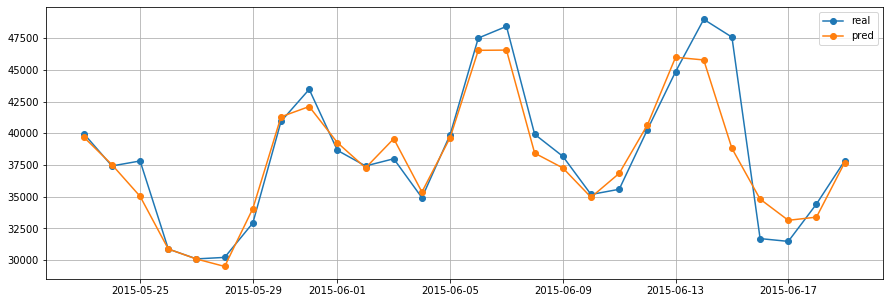

In [8]:
errors = list()
best_iterations = list()
models_level1 = list()

for i,seed in enumerate(SEEDS):
    print(f" {i+1}/{len(SEEDS)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)   
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(_train_data, _valid_index)
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);    
    _fcaster.fit(fit_kwargs={"verbose_eval":25})
    models_level1.append(_fcaster)

    errors.append(_fcaster.model.model.best_score["valid_0"]["rmse"]/scale_factor)
    best_iterations.append(_fcaster.best_iteration)

    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])    
    predictions = pd.merge(predictions,
                           _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
                           how="inner", 
                           on=["ds"]).rename({"y_raw":"y"}, axis=1)
    
    print(f"RMSE: {errors[-1]*scale_factor}")
    print(f"RMSSE: {errors[-1]}")
    plt.figure(figsize=(15,5))
    plt.plot_date(predictions.ds, predictions.y, "o-", label="real")
    plt.plot_date(predictions.ds, predictions.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

rmse: 1996.1397055548389
rmsse: 0.33684364218482155


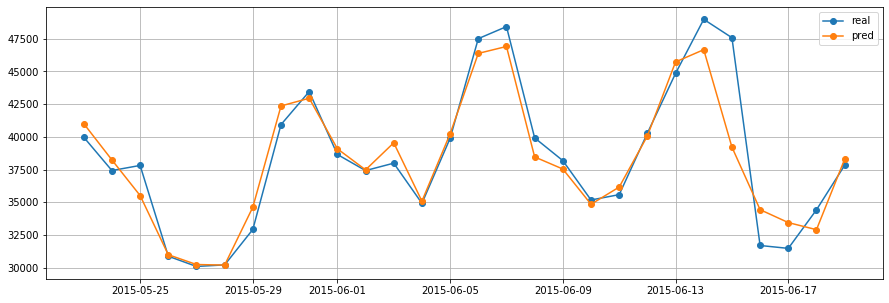

In [9]:
all_predictions = [_fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")]) for _fcaster in models_level1]

forecast_level1 = all_predictions[0].copy(deep=True)
forecast_level1["y_pred"] = np.mean([_prediction.y_pred.values for _prediction in all_predictions], axis=0)

mrg = pd.merge(forecast_level1,
               _fcaster.valid_features.loc[:, ["ds","y_raw"]], 
               how="inner", 
               on=["ds"])
rmse = compute_rmse(mrg.y_raw.values, mrg.y_pred.values)
rmsse = rmse/scale_factor
print(f"rmse: {rmse}")
print(f"rmsse: {rmsse}")

plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y_raw, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred, "o-", label="pred")
plt.legend(loc="best")
plt.grid()
plt.show()

In [10]:
del data
gc.collect()

17665

***
# Level 2

In [11]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["state_id","ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["state_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

weights_level2 = pd.read_parquet("../input/weights_level2.parquet")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level2 = compute_scaling(scaling_input, agg_columns=["state_id"]).rename({"q":"s"}, axis=1)

# outlier removal
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

In [12]:
model_params = {
    'objective': 'l2', 
    'metric': 'None', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'num_threads': 10, 
    'learning_rate': 0.2893587542945107, 
    'num_leaves': 12, 
    'max_bin': 97, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.8, 
    'min_data_in_leaf': 11, 
    'min_gain_to_split': 100, 
    'lambda_l2': 5.781131218800134, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "state_id":"default",
        "event_name_1":"default"},
    "ts_uid_columns":["state_id"],
    
}

In [13]:
# 4+ years of history
train_history = 1800

In [14]:
errors = list()
best_iterations = list()

models_level2 = list()

for i,seed in enumerate(SEEDS):
    print(f" {i+1}/{len(SEEDS)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)   
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(_train_data, ts_uid_columns=["state_id"])
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = _WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level2, 
                                scales_level2,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    models_level2.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 3/3 [00:00<00:00, 5662.88it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.504899
[50]	valid_0's wrmsse: 0.478886
[75]	valid_0's wrmsse: 0.465563
[100]	valid_0's wrmsse: 0.452908
[125]	valid_0's wrmsse: 0.45003
[150]	valid_0's wrmsse: 0.453317
[175]	valid_0's wrmsse: 0.455657
[200]	valid_0's wrmsse: 0.459346
[225]	valid_0's wrmsse: 0.458642
[250]	valid_0's wrmsse: 0.464236
[275]	valid_0's wrmsse: 0.464052
[300]	valid_0's wrmsse: 0.460786
[325]	valid_0's wrmsse: 0.457902
[350]	valid_0's wrmsse: 0.457239
[375]	valid_0's wrmsse: 0.459
[400]	valid_0's wrmsse: 0.458046
[425]	valid_0's wrmsse: 0.454257
Early stopping, best iteration is:
[131]	valid_0's wrmsse: 0.448542
############################################### 2/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 3/3 [00:00<00:00, 1092.46it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.522963
[50]	valid_0's wrmsse: 0.489203
[75]	valid_0's wrmsse: 0.476063
[100]	valid_0's wrmsse: 0.468197
[125]	valid_0's wrmsse: 0.456984
[150]	valid_0's wrmsse: 0.458107
[175]	valid_0's wrmsse: 0.455324
[200]	valid_0's wrmsse: 0.457457
[225]	valid_0's wrmsse: 0.460619
[250]	valid_0's wrmsse: 0.454927
[275]	valid_0's wrmsse: 0.451646
[300]	valid_0's wrmsse: 0.448691
[325]	valid_0's wrmsse: 0.448652
[350]	valid_0's wrmsse: 0.447441
[375]	valid_0's wrmsse: 0.447495
[400]	valid_0's wrmsse: 0.447237
[425]	valid_0's wrmsse: 0.447359
[450]	valid_0's wrmsse: 0.450173
[475]	valid_0's wrmsse: 0.451236
[500]	valid_0's wrmsse: 0.451054
[525]	valid_0's wrmsse: 0.449026
[550]	valid_0's wrmsse: 0.453451
[575]	valid_0's wrmsse: 0.455484
[600]	valid_0's wrmsse: 0.457479
[625]	valid_0's wrmsse: 0.457334
[650]	valid_0's wrmsse: 0.460199
[675]	valid_0's wrmsse: 0.461146
Early stopping, best iteration is:
[383]	valid_0's

100%|██████████| 3/3 [00:00<00:00, 4120.14it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.505087
[50]	valid_0's wrmsse: 0.486871
[75]	valid_0's wrmsse: 0.47201
[100]	valid_0's wrmsse: 0.466327
[125]	valid_0's wrmsse: 0.461404
[150]	valid_0's wrmsse: 0.459707
[175]	valid_0's wrmsse: 0.465475
[200]	valid_0's wrmsse: 0.464648
[225]	valid_0's wrmsse: 0.463007
[250]	valid_0's wrmsse: 0.462424
[275]	valid_0's wrmsse: 0.461012
[300]	valid_0's wrmsse: 0.463303
[325]	valid_0's wrmsse: 0.462269
[350]	valid_0's wrmsse: 0.465904
[375]	valid_0's wrmsse: 0.466039
[400]	valid_0's wrmsse: 0.464932
[425]	valid_0's wrmsse: 0.463915
[450]	valid_0's wrmsse: 0.461393
Early stopping, best iteration is:
[155]	valid_0's wrmsse: 0.457473
############################################### 4/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
##############################################################################

100%|██████████| 3/3 [00:00<00:00, 2458.56it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.503681
[50]	valid_0's wrmsse: 0.471945
[75]	valid_0's wrmsse: 0.465544
[100]	valid_0's wrmsse: 0.455773
[125]	valid_0's wrmsse: 0.448564
[150]	valid_0's wrmsse: 0.446638
[175]	valid_0's wrmsse: 0.439497
[200]	valid_0's wrmsse: 0.435221
[225]	valid_0's wrmsse: 0.439429
[250]	valid_0's wrmsse: 0.436206
[275]	valid_0's wrmsse: 0.439375
[300]	valid_0's wrmsse: 0.438788
[325]	valid_0's wrmsse: 0.435196
[350]	valid_0's wrmsse: 0.431656
[375]	valid_0's wrmsse: 0.432658
[400]	valid_0's wrmsse: 0.43211
[425]	valid_0's wrmsse: 0.430717
[450]	valid_0's wrmsse: 0.429811
[475]	valid_0's wrmsse: 0.426336
[500]	valid_0's wrmsse: 0.426703
[525]	valid_0's wrmsse: 0.425715
[550]	valid_0's wrmsse: 0.428016
[575]	valid_0's wrmsse: 0.433679
[600]	valid_0's wrmsse: 0.429241
[625]	valid_0's wrmsse: 0.429059
[650]	valid_0's wrmsse: 0.42926
[675]	valid_0's wrmsse: 0.432602
[700]	valid_0's wrmsse: 0.433811
[725]	valid_0's wrm

100%|██████████| 3/3 [00:00<00:00, 5086.06it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.519443
[50]	valid_0's wrmsse: 0.484038
[75]	valid_0's wrmsse: 0.463375
[100]	valid_0's wrmsse: 0.452406
[125]	valid_0's wrmsse: 0.449089
[150]	valid_0's wrmsse: 0.455714
[175]	valid_0's wrmsse: 0.456941
[200]	valid_0's wrmsse: 0.453579
[225]	valid_0's wrmsse: 0.44879
[250]	valid_0's wrmsse: 0.448008
[275]	valid_0's wrmsse: 0.443969
[300]	valid_0's wrmsse: 0.442286
[325]	valid_0's wrmsse: 0.448209
[350]	valid_0's wrmsse: 0.450583
[375]	valid_0's wrmsse: 0.452492
[400]	valid_0's wrmsse: 0.447926
[425]	valid_0's wrmsse: 0.449116
[450]	valid_0's wrmsse: 0.450252
[475]	valid_0's wrmsse: 0.450474
[500]	valid_0's wrmsse: 0.453933
[525]	valid_0's wrmsse: 0.454094
[550]	valid_0's wrmsse: 0.452634
[575]	valid_0's wrmsse: 0.454738
Early stopping, best iteration is:
[297]	valid_0's wrmsse: 0.442168
############################################### 6/20 ###############################################
##### Validati

100%|██████████| 3/3 [00:00<00:00, 230.27it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.513421
[50]	valid_0's wrmsse: 0.480181
[75]	valid_0's wrmsse: 0.463505
[100]	valid_0's wrmsse: 0.442404
[125]	valid_0's wrmsse: 0.443116
[150]	valid_0's wrmsse: 0.435941
[175]	valid_0's wrmsse: 0.431279
[200]	valid_0's wrmsse: 0.429369
[225]	valid_0's wrmsse: 0.426862
[250]	valid_0's wrmsse: 0.421841
[275]	valid_0's wrmsse: 0.418991
[300]	valid_0's wrmsse: 0.419483
[325]	valid_0's wrmsse: 0.41143
[350]	valid_0's wrmsse: 0.41075
[375]	valid_0's wrmsse: 0.408282
[400]	valid_0's wrmsse: 0.40955
[425]	valid_0's wrmsse: 0.405104
[450]	valid_0's wrmsse: 0.408024
[475]	valid_0's wrmsse: 0.40989
[500]	valid_0's wrmsse: 0.409265
[525]	valid_0's wrmsse: 0.409871
[550]	valid_0's wrmsse: 0.413649
[575]	valid_0's wrmsse: 0.413167
[600]	valid_0's wrmsse: 0.410413
[625]	valid_0's wrmsse: 0.411164
[650]	valid_0's wrmsse: 0.412004
[675]	valid_0's wrmsse: 0.409495
[700]	valid_0's wrmsse: 0.40892
[725]	valid_0's wrmsse

100%|██████████| 3/3 [00:00<00:00, 4880.88it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.509239
[50]	valid_0's wrmsse: 0.483176
[75]	valid_0's wrmsse: 0.463581
[100]	valid_0's wrmsse: 0.456008
[125]	valid_0's wrmsse: 0.457383
[150]	valid_0's wrmsse: 0.453694
[175]	valid_0's wrmsse: 0.450075
[200]	valid_0's wrmsse: 0.445826
[225]	valid_0's wrmsse: 0.450127
[250]	valid_0's wrmsse: 0.455255
[275]	valid_0's wrmsse: 0.449322
[300]	valid_0's wrmsse: 0.452677
[325]	valid_0's wrmsse: 0.455025
[350]	valid_0's wrmsse: 0.453787
[375]	valid_0's wrmsse: 0.452173
[400]	valid_0's wrmsse: 0.452136
[425]	valid_0's wrmsse: 0.45085
[450]	valid_0's wrmsse: 0.452327
[475]	valid_0's wrmsse: 0.452105
Early stopping, best iteration is:
[195]	valid_0's wrmsse: 0.444305
############################################### 8/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
#############################################

100%|██████████| 3/3 [00:00<00:00, 3963.12it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.512905
[50]	valid_0's wrmsse: 0.476028
[75]	valid_0's wrmsse: 0.461222
[100]	valid_0's wrmsse: 0.454526
[125]	valid_0's wrmsse: 0.452117
[150]	valid_0's wrmsse: 0.442493
[175]	valid_0's wrmsse: 0.438794
[200]	valid_0's wrmsse: 0.435807
[225]	valid_0's wrmsse: 0.436442
[250]	valid_0's wrmsse: 0.432937
[275]	valid_0's wrmsse: 0.43642
[300]	valid_0's wrmsse: 0.434685
[325]	valid_0's wrmsse: 0.433214
[350]	valid_0's wrmsse: 0.434837
[375]	valid_0's wrmsse: 0.435385
[400]	valid_0's wrmsse: 0.435266
[425]	valid_0's wrmsse: 0.435519
[450]	valid_0's wrmsse: 0.436429
[475]	valid_0's wrmsse: 0.437249
[500]	valid_0's wrmsse: 0.443211
[525]	valid_0's wrmsse: 0.443449
[550]	valid_0's wrmsse: 0.445371
[575]	valid_0's wrmsse: 0.444777
[600]	valid_0's wrmsse: 0.447954
Early stopping, best iteration is:
[322]	valid_0's wrmsse: 0.432523
############################################### 9/20 #############################

100%|██████████| 3/3 [00:00<00:00, 2363.43it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.508481
[50]	valid_0's wrmsse: 0.480647
[75]	valid_0's wrmsse: 0.455687
[100]	valid_0's wrmsse: 0.454284
[125]	valid_0's wrmsse: 0.447118
[150]	valid_0's wrmsse: 0.439016
[175]	valid_0's wrmsse: 0.434198
[200]	valid_0's wrmsse: 0.431145
[225]	valid_0's wrmsse: 0.432656
[250]	valid_0's wrmsse: 0.42772
[275]	valid_0's wrmsse: 0.425359
[300]	valid_0's wrmsse: 0.424703
[325]	valid_0's wrmsse: 0.422471
[350]	valid_0's wrmsse: 0.423978
[375]	valid_0's wrmsse: 0.43155
[400]	valid_0's wrmsse: 0.432309
[425]	valid_0's wrmsse: 0.433347
[450]	valid_0's wrmsse: 0.436398
[475]	valid_0's wrmsse: 0.433064
[500]	valid_0's wrmsse: 0.435189
[525]	valid_0's wrmsse: 0.434658
[550]	valid_0's wrmsse: 0.435512
[575]	valid_0's wrmsse: 0.435456
[600]	valid_0's wrmsse: 0.438319
Early stopping, best iteration is:
[316]	valid_0's wrmsse: 0.421339
############################################## 10/20 ##############################

100%|██████████| 3/3 [00:00<00:00, 4762.65it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.501189
[50]	valid_0's wrmsse: 0.460377
[75]	valid_0's wrmsse: 0.446373
[100]	valid_0's wrmsse: 0.439505
[125]	valid_0's wrmsse: 0.4354
[150]	valid_0's wrmsse: 0.432512
[175]	valid_0's wrmsse: 0.435279
[200]	valid_0's wrmsse: 0.431259
[225]	valid_0's wrmsse: 0.431512
[250]	valid_0's wrmsse: 0.434994
[275]	valid_0's wrmsse: 0.433635
[300]	valid_0's wrmsse: 0.436101
[325]	valid_0's wrmsse: 0.434159
[350]	valid_0's wrmsse: 0.433836
[375]	valid_0's wrmsse: 0.43524
[400]	valid_0's wrmsse: 0.440463
[425]	valid_0's wrmsse: 0.443367
[450]	valid_0's wrmsse: 0.446277
[475]	valid_0's wrmsse: 0.449552
[500]	valid_0's wrmsse: 0.454509
Early stopping, best iteration is:
[217]	valid_0's wrmsse: 0.429869
############################################## 11/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
##############

100%|██████████| 3/3 [00:00<00:00, 2238.16it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.514534
[50]	valid_0's wrmsse: 0.492691
[75]	valid_0's wrmsse: 0.477508
[100]	valid_0's wrmsse: 0.471677
[125]	valid_0's wrmsse: 0.479419
[150]	valid_0's wrmsse: 0.47393
[175]	valid_0's wrmsse: 0.465744
[200]	valid_0's wrmsse: 0.464995
[225]	valid_0's wrmsse: 0.458801
[250]	valid_0's wrmsse: 0.457663
[275]	valid_0's wrmsse: 0.45892
[300]	valid_0's wrmsse: 0.460098
[325]	valid_0's wrmsse: 0.454841
[350]	valid_0's wrmsse: 0.456554
[375]	valid_0's wrmsse: 0.45732
[400]	valid_0's wrmsse: 0.456201
[425]	valid_0's wrmsse: 0.454861
[450]	valid_0's wrmsse: 0.461979
[475]	valid_0's wrmsse: 0.462921
[500]	valid_0's wrmsse: 0.466479
[525]	valid_0's wrmsse: 0.464842
[550]	valid_0's wrmsse: 0.468211
[575]	valid_0's wrmsse: 0.467968
[600]	valid_0's wrmsse: 0.468973
Early stopping, best iteration is:
[320]	valid_0's wrmsse: 0.452789
############################################## 12/20 ###############################

100%|██████████| 3/3 [00:00<00:00, 1882.54it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.507508
[50]	valid_0's wrmsse: 0.46724
[75]	valid_0's wrmsse: 0.451035
[100]	valid_0's wrmsse: 0.44823
[125]	valid_0's wrmsse: 0.44026
[150]	valid_0's wrmsse: 0.443848
[175]	valid_0's wrmsse: 0.435663
[200]	valid_0's wrmsse: 0.429456
[225]	valid_0's wrmsse: 0.428297
[250]	valid_0's wrmsse: 0.42566
[275]	valid_0's wrmsse: 0.427164
[300]	valid_0's wrmsse: 0.428431
[325]	valid_0's wrmsse: 0.428366
[350]	valid_0's wrmsse: 0.426444
[375]	valid_0's wrmsse: 0.42668
[400]	valid_0's wrmsse: 0.423876
[425]	valid_0's wrmsse: 0.421176
[450]	valid_0's wrmsse: 0.424063
[475]	valid_0's wrmsse: 0.426021
[500]	valid_0's wrmsse: 0.431032
[525]	valid_0's wrmsse: 0.428509
[550]	valid_0's wrmsse: 0.432492
[575]	valid_0's wrmsse: 0.431856
[600]	valid_0's wrmsse: 0.431501
[625]	valid_0's wrmsse: 0.434241
[650]	valid_0's wrmsse: 0.434331
[675]	valid_0's wrmsse: 0.432847
[700]	valid_0's wrmsse: 0.433879
Early stopping, best i

100%|██████████| 3/3 [00:00<00:00, 2154.61it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.514941
[50]	valid_0's wrmsse: 0.488658
[75]	valid_0's wrmsse: 0.469157
[100]	valid_0's wrmsse: 0.452789
[125]	valid_0's wrmsse: 0.453568
[150]	valid_0's wrmsse: 0.456708
[175]	valid_0's wrmsse: 0.458351
[200]	valid_0's wrmsse: 0.469276
[225]	valid_0's wrmsse: 0.465122
[250]	valid_0's wrmsse: 0.46299
[275]	valid_0's wrmsse: 0.465117
[300]	valid_0's wrmsse: 0.462054
[325]	valid_0's wrmsse: 0.457386
[350]	valid_0's wrmsse: 0.460124
[375]	valid_0's wrmsse: 0.461042
[400]	valid_0's wrmsse: 0.460458
Early stopping, best iteration is:
[116]	valid_0's wrmsse: 0.450015
############################################## 14/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 3/3 [00:00<00:00, 4498.72it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.511905
[50]	valid_0's wrmsse: 0.480471
[75]	valid_0's wrmsse: 0.453485
[100]	valid_0's wrmsse: 0.44813
[125]	valid_0's wrmsse: 0.44022
[150]	valid_0's wrmsse: 0.437597
[175]	valid_0's wrmsse: 0.425336
[200]	valid_0's wrmsse: 0.424091
[225]	valid_0's wrmsse: 0.422904
[250]	valid_0's wrmsse: 0.423002
[275]	valid_0's wrmsse: 0.425219
[300]	valid_0's wrmsse: 0.423959
[325]	valid_0's wrmsse: 0.421065
[350]	valid_0's wrmsse: 0.425679
[375]	valid_0's wrmsse: 0.427789
[400]	valid_0's wrmsse: 0.427576
[425]	valid_0's wrmsse: 0.430027
[450]	valid_0's wrmsse: 0.427179
[475]	valid_0's wrmsse: 0.428936
Early stopping, best iteration is:
[190]	valid_0's wrmsse: 0.420637
############################################## 15/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
##############################################

100%|██████████| 3/3 [00:00<00:00, 5137.98it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.515261
[50]	valid_0's wrmsse: 0.484033
[75]	valid_0's wrmsse: 0.474696
[100]	valid_0's wrmsse: 0.474028
[125]	valid_0's wrmsse: 0.46671
[150]	valid_0's wrmsse: 0.455011
[175]	valid_0's wrmsse: 0.453773
[200]	valid_0's wrmsse: 0.453451
[225]	valid_0's wrmsse: 0.45201
[250]	valid_0's wrmsse: 0.451393
[275]	valid_0's wrmsse: 0.448759
[300]	valid_0's wrmsse: 0.453353
[325]	valid_0's wrmsse: 0.449304
[350]	valid_0's wrmsse: 0.44809
[375]	valid_0's wrmsse: 0.452126
[400]	valid_0's wrmsse: 0.452086
[425]	valid_0's wrmsse: 0.450565
[450]	valid_0's wrmsse: 0.454771
[475]	valid_0's wrmsse: 0.457673
[500]	valid_0's wrmsse: 0.456053
[525]	valid_0's wrmsse: 0.455247
[550]	valid_0's wrmsse: 0.455912
Early stopping, best iteration is:
[273]	valid_0's wrmsse: 0.447403
############################################## 16/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 0

100%|██████████| 3/3 [00:00<00:00, 3202.57it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.502754
[50]	valid_0's wrmsse: 0.468219
[75]	valid_0's wrmsse: 0.448358
[100]	valid_0's wrmsse: 0.438142
[125]	valid_0's wrmsse: 0.443544
[150]	valid_0's wrmsse: 0.442726
[175]	valid_0's wrmsse: 0.445403
[200]	valid_0's wrmsse: 0.448033
[225]	valid_0's wrmsse: 0.446594
[250]	valid_0's wrmsse: 0.444262
[275]	valid_0's wrmsse: 0.443566
[300]	valid_0's wrmsse: 0.438408
[325]	valid_0's wrmsse: 0.437606
[350]	valid_0's wrmsse: 0.437256
[375]	valid_0's wrmsse: 0.438633
[400]	valid_0's wrmsse: 0.436353
[425]	valid_0's wrmsse: 0.436143
[450]	valid_0's wrmsse: 0.437735
[475]	valid_0's wrmsse: 0.438329
[500]	valid_0's wrmsse: 0.435705
[525]	valid_0's wrmsse: 0.434528
[550]	valid_0's wrmsse: 0.433886
[575]	valid_0's wrmsse: 0.434818
[600]	valid_0's wrmsse: 0.435948
[625]	valid_0's wrmsse: 0.435447
[650]	valid_0's wrmsse: 0.434806
[675]	valid_0's wrmsse: 0.43848
[700]	valid_0's wrmsse: 0.440505
[725]	valid_0's wr

100%|██████████| 3/3 [00:00<00:00, 4643.14it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.504266
[50]	valid_0's wrmsse: 0.470677
[75]	valid_0's wrmsse: 0.461525
[100]	valid_0's wrmsse: 0.454615
[125]	valid_0's wrmsse: 0.455544
[150]	valid_0's wrmsse: 0.449039
[175]	valid_0's wrmsse: 0.444997
[200]	valid_0's wrmsse: 0.440506
[225]	valid_0's wrmsse: 0.437325
[250]	valid_0's wrmsse: 0.437171
[275]	valid_0's wrmsse: 0.43927
[300]	valid_0's wrmsse: 0.438473
[325]	valid_0's wrmsse: 0.441961
[350]	valid_0's wrmsse: 0.443239
[375]	valid_0's wrmsse: 0.437982
[400]	valid_0's wrmsse: 0.436448
[425]	valid_0's wrmsse: 0.434924
[450]	valid_0's wrmsse: 0.436108
[475]	valid_0's wrmsse: 0.44179
[500]	valid_0's wrmsse: 0.440581
[525]	valid_0's wrmsse: 0.440898
[550]	valid_0's wrmsse: 0.440656
[575]	valid_0's wrmsse: 0.440592
[600]	valid_0's wrmsse: 0.443692
[625]	valid_0's wrmsse: 0.441994
[650]	valid_0's wrmsse: 0.4445
[675]	valid_0's wrmsse: 0.444613
[700]	valid_0's wrmsse: 0.443987
[725]	valid_0's wrmss

100%|██████████| 3/3 [00:00<00:00, 267.48it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.50498
[50]	valid_0's wrmsse: 0.480602
[75]	valid_0's wrmsse: 0.466577
[100]	valid_0's wrmsse: 0.452538
[125]	valid_0's wrmsse: 0.452556
[150]	valid_0's wrmsse: 0.45307
[175]	valid_0's wrmsse: 0.451874
[200]	valid_0's wrmsse: 0.453379
[225]	valid_0's wrmsse: 0.451911
[250]	valid_0's wrmsse: 0.453937
[275]	valid_0's wrmsse: 0.452949
[300]	valid_0's wrmsse: 0.454245
[325]	valid_0's wrmsse: 0.450186
[350]	valid_0's wrmsse: 0.450037
[375]	valid_0's wrmsse: 0.449214
[400]	valid_0's wrmsse: 0.451233
[425]	valid_0's wrmsse: 0.4524
[450]	valid_0's wrmsse: 0.449663
[475]	valid_0's wrmsse: 0.44971
[500]	valid_0's wrmsse: 0.453669
[525]	valid_0's wrmsse: 0.452514
[550]	valid_0's wrmsse: 0.450896
[575]	valid_0's wrmsse: 0.451369
[600]	valid_0's wrmsse: 0.451954
[625]	valid_0's wrmsse: 0.452259
[650]	valid_0's wrmsse: 0.447568
[675]	valid_0's wrmsse: 0.448251
[700]	valid_0's wrmsse: 0.450013
[725]	valid_0's wrmsse

100%|██████████| 3/3 [00:00<00:00, 5098.42it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.522433
[50]	valid_0's wrmsse: 0.48323
[75]	valid_0's wrmsse: 0.471123
[100]	valid_0's wrmsse: 0.46633
[125]	valid_0's wrmsse: 0.464676
[150]	valid_0's wrmsse: 0.460206
[175]	valid_0's wrmsse: 0.460463
[200]	valid_0's wrmsse: 0.457564
[225]	valid_0's wrmsse: 0.453935
[250]	valid_0's wrmsse: 0.451557
[275]	valid_0's wrmsse: 0.456193
[300]	valid_0's wrmsse: 0.459384
[325]	valid_0's wrmsse: 0.45587
[350]	valid_0's wrmsse: 0.456918
[375]	valid_0's wrmsse: 0.456679
[400]	valid_0's wrmsse: 0.457808
[425]	valid_0's wrmsse: 0.454043
[450]	valid_0's wrmsse: 0.458473
[475]	valid_0's wrmsse: 0.453487
[500]	valid_0's wrmsse: 0.454641
[525]	valid_0's wrmsse: 0.453223
[550]	valid_0's wrmsse: 0.455822
Early stopping, best iteration is:
[250]	valid_0's wrmsse: 0.451557
############################################## 20/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 0

100%|██████████| 3/3 [00:00<00:00, 3733.80it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.506352
[50]	valid_0's wrmsse: 0.482363
[75]	valid_0's wrmsse: 0.462462
[100]	valid_0's wrmsse: 0.445484
[125]	valid_0's wrmsse: 0.441989
[150]	valid_0's wrmsse: 0.437738
[175]	valid_0's wrmsse: 0.427442
[200]	valid_0's wrmsse: 0.433646
[225]	valid_0's wrmsse: 0.432987
[250]	valid_0's wrmsse: 0.433069
[275]	valid_0's wrmsse: 0.432702
[300]	valid_0's wrmsse: 0.433462
[325]	valid_0's wrmsse: 0.429891
[350]	valid_0's wrmsse: 0.429642
[375]	valid_0's wrmsse: 0.4287
[400]	valid_0's wrmsse: 0.428795
[425]	valid_0's wrmsse: 0.434201
[450]	valid_0's wrmsse: 0.434919
[475]	valid_0's wrmsse: 0.435002
Early stopping, best iteration is:
[176]	valid_0's wrmsse: 0.427411


In [15]:
all_predictions = [_fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")]) for _fcaster in models_level2]
forecast_level2 = all_predictions[0].copy(deep=True)
forecast_level2["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

In [16]:
mrg = pd.merge(forecast_level2,
               _fcaster.valid_features.loc[:, ["ds","state_id","y_raw"]], 
               how="inner", 
               on=["ds","state_id"])

mrg["sq_error"] = mrg.eval("(y_raw-y_pred)**2")

rmsse = (mrg
         .groupby(["state_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level2, how="left", on=["state_id"])
         .merge(weights_level2, how="left", on=["state_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.42606077417115024


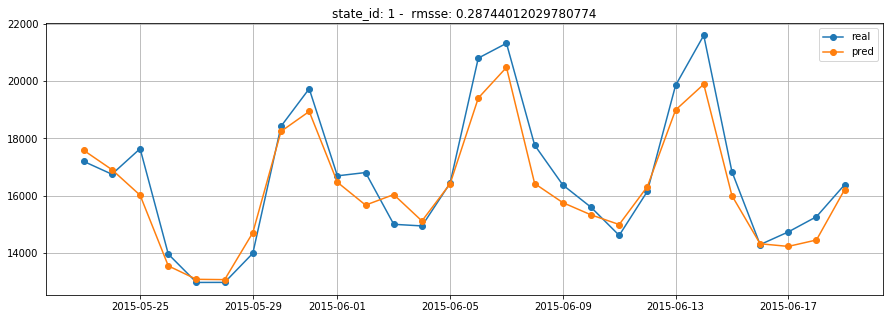

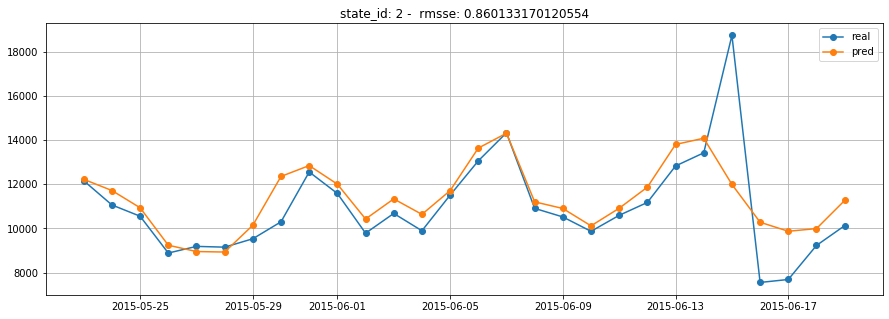

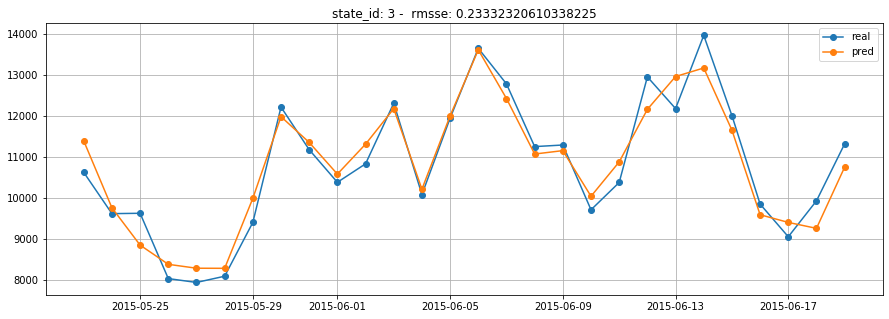

In [17]:
for state_id in [1,2,3]:    
    df_cut = mrg.query("state_id == @state_id")
    rmsse = np.sqrt(df_cut.eval("(y_raw-y_pred)**2").mean()) / scales_level2.query("state_id == @state_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"state_id: {state_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y_raw, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
# Level 3

In [18]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["store_id","ds"])
        .agg({"q":"sum",
              "state_id":lambda x: int(x.unique()),
              "snap":lambda x: int(x.unique()),
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["store_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

weights_level3 = pd.read_parquet("../input/weights_level3.parquet")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level3 = compute_scaling(scaling_input, agg_columns=["store_id"]).rename({"q":"s"}, axis=1)

# outlier removal
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

In [19]:
model_params = {
    'objective': 'l2', 
    'metric': 'None', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'num_threads': 10, 
    'learning_rate': 0.29527215922256966, 
    'num_leaves': 31, 'max_bin': 163, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.6000000000000001, 
    'min_data_in_leaf': 24, 
    'min_gain_to_split': 1, 
    'lambda_l2': 0.504534786307544, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "store_id":"default",
        "state_id":"default",
        "event_name_1":"default",
        "snap":"default"},
    "ts_uid_columns":["store_id"],  
}

In [20]:
# 4+ years of history
train_history = 1800

In [21]:
errors = list()
best_iterations = list()

models_level3 = list()

for i,seed in enumerate(SEEDS):
    print(f" {i+1}/{len(SEEDS)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)   
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(_train_data, ts_uid_columns=["store_id"])
    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = _WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                 weights_level3, 
                                 scales_level3,
                                 ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    models_level3.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 13464.86it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.563422
[50]	valid_0's wrmsse: 0.550049
[75]	valid_0's wrmsse: 0.551901
[100]	valid_0's wrmsse: 0.553609
[125]	valid_0's wrmsse: 0.550643
[150]	valid_0's wrmsse: 0.558893
[175]	valid_0's wrmsse: 0.555329
[200]	valid_0's wrmsse: 0.560941
[225]	valid_0's wrmsse: 0.559652
[250]	valid_0's wrmsse: 0.564653
[275]	valid_0's wrmsse: 0.566038
[300]	valid_0's wrmsse: 0.574828
[325]	valid_0's wrmsse: 0.575882
Early stopping, best iteration is:
[41]	valid_0's wrmsse: 0.545151
############################################### 2/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 15809.66it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.560916
[50]	valid_0's wrmsse: 0.561168
[75]	valid_0's wrmsse: 0.566019
[100]	valid_0's wrmsse: 0.57022
[125]	valid_0's wrmsse: 0.572329
[150]	valid_0's wrmsse: 0.57649
[175]	valid_0's wrmsse: 0.572645
[200]	valid_0's wrmsse: 0.583023
[225]	valid_0's wrmsse: 0.583448
[250]	valid_0's wrmsse: 0.581023
[275]	valid_0's wrmsse: 0.581211
[300]	valid_0's wrmsse: 0.587029
[325]	valid_0's wrmsse: 0.588885
Early stopping, best iteration is:
[42]	valid_0's wrmsse: 0.551015
############################################### 3/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 5737.76it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.561983
[50]	valid_0's wrmsse: 0.55046
[75]	valid_0's wrmsse: 0.556869
[100]	valid_0's wrmsse: 0.552737
[125]	valid_0's wrmsse: 0.554003
[150]	valid_0's wrmsse: 0.558572
[175]	valid_0's wrmsse: 0.562824
[200]	valid_0's wrmsse: 0.564435
[225]	valid_0's wrmsse: 0.561485
[250]	valid_0's wrmsse: 0.563582
[275]	valid_0's wrmsse: 0.559984
[300]	valid_0's wrmsse: 0.570986
[325]	valid_0's wrmsse: 0.567023
Early stopping, best iteration is:
[48]	valid_0's wrmsse: 0.549087
############################################### 4/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 11275.01it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.56364
[50]	valid_0's wrmsse: 0.54241
[75]	valid_0's wrmsse: 0.544862
[100]	valid_0's wrmsse: 0.539724
[125]	valid_0's wrmsse: 0.547949
[150]	valid_0's wrmsse: 0.550351
[175]	valid_0's wrmsse: 0.550652
[200]	valid_0's wrmsse: 0.557535
[225]	valid_0's wrmsse: 0.556485
[250]	valid_0's wrmsse: 0.557647
[275]	valid_0's wrmsse: 0.554132
[300]	valid_0's wrmsse: 0.558233
[325]	valid_0's wrmsse: 0.562422
[350]	valid_0's wrmsse: 0.558915
[375]	valid_0's wrmsse: 0.560192
Early stopping, best iteration is:
[98]	valid_0's wrmsse: 0.539436
############################################### 5/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 13144.17it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.556003
[50]	valid_0's wrmsse: 0.539927
[75]	valid_0's wrmsse: 0.542373
[100]	valid_0's wrmsse: 0.54497
[125]	valid_0's wrmsse: 0.547343
[150]	valid_0's wrmsse: 0.548176
[175]	valid_0's wrmsse: 0.552787
[200]	valid_0's wrmsse: 0.556534
[225]	valid_0's wrmsse: 0.553337
[250]	valid_0's wrmsse: 0.558703
[275]	valid_0's wrmsse: 0.563358
[300]	valid_0's wrmsse: 0.562808
[325]	valid_0's wrmsse: 0.561997
[350]	valid_0's wrmsse: 0.565732
Early stopping, best iteration is:
[59]	valid_0's wrmsse: 0.53475
############################################### 6/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 14873.42it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.558436
[50]	valid_0's wrmsse: 0.539362
[75]	valid_0's wrmsse: 0.542808
[100]	valid_0's wrmsse: 0.547056
[125]	valid_0's wrmsse: 0.544004
[150]	valid_0's wrmsse: 0.535847
[175]	valid_0's wrmsse: 0.540121
[200]	valid_0's wrmsse: 0.5412
[225]	valid_0's wrmsse: 0.541292
[250]	valid_0's wrmsse: 0.541126
[275]	valid_0's wrmsse: 0.542545
[300]	valid_0's wrmsse: 0.549329
[325]	valid_0's wrmsse: 0.551541
[350]	valid_0's wrmsse: 0.551199
Early stopping, best iteration is:
[57]	valid_0's wrmsse: 0.534473
############################################### 7/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 8452.85it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.561853
[50]	valid_0's wrmsse: 0.551331
[75]	valid_0's wrmsse: 0.554505
[100]	valid_0's wrmsse: 0.549087
[125]	valid_0's wrmsse: 0.548832
[150]	valid_0's wrmsse: 0.54964
[175]	valid_0's wrmsse: 0.54925
[200]	valid_0's wrmsse: 0.551883
[225]	valid_0's wrmsse: 0.555219
[250]	valid_0's wrmsse: 0.560654
[275]	valid_0's wrmsse: 0.566169
[300]	valid_0's wrmsse: 0.565499
[325]	valid_0's wrmsse: 0.572161
[350]	valid_0's wrmsse: 0.567882
[375]	valid_0's wrmsse: 0.573224
[400]	valid_0's wrmsse: 0.573174
Early stopping, best iteration is:
[114]	valid_0's wrmsse: 0.544833
############################################### 8/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 11663.80it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.571963
[50]	valid_0's wrmsse: 0.562023
[75]	valid_0's wrmsse: 0.565058
[100]	valid_0's wrmsse: 0.55721
[125]	valid_0's wrmsse: 0.552583
[150]	valid_0's wrmsse: 0.556587
[175]	valid_0's wrmsse: 0.564032
[200]	valid_0's wrmsse: 0.567665
[225]	valid_0's wrmsse: 0.568501
[250]	valid_0's wrmsse: 0.571114
[275]	valid_0's wrmsse: 0.571257
[300]	valid_0's wrmsse: 0.575354
[325]	valid_0's wrmsse: 0.572962
[350]	valid_0's wrmsse: 0.572362
[375]	valid_0's wrmsse: 0.568775
[400]	valid_0's wrmsse: 0.570097
[425]	valid_0's wrmsse: 0.571528
Early stopping, best iteration is:
[125]	valid_0's wrmsse: 0.552583
############################################### 9/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 15632.89it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.567908
[50]	valid_0's wrmsse: 0.546986
[75]	valid_0's wrmsse: 0.550004
[100]	valid_0's wrmsse: 0.543249
[125]	valid_0's wrmsse: 0.54562
[150]	valid_0's wrmsse: 0.551793
[175]	valid_0's wrmsse: 0.55173
[200]	valid_0's wrmsse: 0.557984
[225]	valid_0's wrmsse: 0.563942
[250]	valid_0's wrmsse: 0.57745
[275]	valid_0's wrmsse: 0.576357
[300]	valid_0's wrmsse: 0.576812
[325]	valid_0's wrmsse: 0.579661
[350]	valid_0's wrmsse: 0.581619
[375]	valid_0's wrmsse: 0.579464
[400]	valid_0's wrmsse: 0.579306
Early stopping, best iteration is:
[107]	valid_0's wrmsse: 0.541555
############################################## 10/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 12028.40it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.561017
[50]	valid_0's wrmsse: 0.54663
[75]	valid_0's wrmsse: 0.556334
[100]	valid_0's wrmsse: 0.559207
[125]	valid_0's wrmsse: 0.561806
[150]	valid_0's wrmsse: 0.566303
[175]	valid_0's wrmsse: 0.567856
[200]	valid_0's wrmsse: 0.564916
[225]	valid_0's wrmsse: 0.565252
[250]	valid_0's wrmsse: 0.564608
[275]	valid_0's wrmsse: 0.565217
[300]	valid_0's wrmsse: 0.564364
[325]	valid_0's wrmsse: 0.564467
[350]	valid_0's wrmsse: 0.568833
Early stopping, best iteration is:
[54]	valid_0's wrmsse: 0.544342
############################################## 11/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 15380.65it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.557617
[50]	valid_0's wrmsse: 0.555174
[75]	valid_0's wrmsse: 0.554256
[100]	valid_0's wrmsse: 0.558498
[125]	valid_0's wrmsse: 0.553641
[150]	valid_0's wrmsse: 0.550262
[175]	valid_0's wrmsse: 0.54912
[200]	valid_0's wrmsse: 0.557359
[225]	valid_0's wrmsse: 0.558238
[250]	valid_0's wrmsse: 0.553487
[275]	valid_0's wrmsse: 0.556786
[300]	valid_0's wrmsse: 0.56183
[325]	valid_0's wrmsse: 0.566326
[350]	valid_0's wrmsse: 0.563717
[375]	valid_0's wrmsse: 0.569948
[400]	valid_0's wrmsse: 0.569887
[425]	valid_0's wrmsse: 0.570231
[450]	valid_0's wrmsse: 0.572585
Early stopping, best iteration is:
[165]	valid_0's wrmsse: 0.54397
############################################## 12/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
################################################################################

100%|██████████| 10/10 [00:00<00:00, 4283.84it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.560036
[50]	valid_0's wrmsse: 0.545976
[75]	valid_0's wrmsse: 0.550005
[100]	valid_0's wrmsse: 0.551355
[125]	valid_0's wrmsse: 0.55031
[150]	valid_0's wrmsse: 0.554807
[175]	valid_0's wrmsse: 0.553244
[200]	valid_0's wrmsse: 0.556248
[225]	valid_0's wrmsse: 0.553634
[250]	valid_0's wrmsse: 0.558029
[275]	valid_0's wrmsse: 0.560639
[300]	valid_0's wrmsse: 0.563968
[325]	valid_0's wrmsse: 0.564555
[350]	valid_0's wrmsse: 0.566253
Early stopping, best iteration is:
[54]	valid_0's wrmsse: 0.544047
############################################## 13/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 11564.11it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.568151
[50]	valid_0's wrmsse: 0.559251
[75]	valid_0's wrmsse: 0.555105
[100]	valid_0's wrmsse: 0.551879
[125]	valid_0's wrmsse: 0.55399
[150]	valid_0's wrmsse: 0.546875
[175]	valid_0's wrmsse: 0.556685
[200]	valid_0's wrmsse: 0.564359
[225]	valid_0's wrmsse: 0.568444
[250]	valid_0's wrmsse: 0.56693
[275]	valid_0's wrmsse: 0.570149
[300]	valid_0's wrmsse: 0.572014
[325]	valid_0's wrmsse: 0.571683
[350]	valid_0's wrmsse: 0.574252
[375]	valid_0's wrmsse: 0.575318
[400]	valid_0's wrmsse: 0.577646
[425]	valid_0's wrmsse: 0.581311
Early stopping, best iteration is:
[144]	valid_0's wrmsse: 0.546803
############################################## 14/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 14046.56it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.576177
[50]	valid_0's wrmsse: 0.563128
[75]	valid_0's wrmsse: 0.5566
[100]	valid_0's wrmsse: 0.552773
[125]	valid_0's wrmsse: 0.557363
[150]	valid_0's wrmsse: 0.556525
[175]	valid_0's wrmsse: 0.557369
[200]	valid_0's wrmsse: 0.555217
[225]	valid_0's wrmsse: 0.555594
[250]	valid_0's wrmsse: 0.561628
[275]	valid_0's wrmsse: 0.568409
[300]	valid_0's wrmsse: 0.572906
[325]	valid_0's wrmsse: 0.574678
[350]	valid_0's wrmsse: 0.574418
[375]	valid_0's wrmsse: 0.575454
[400]	valid_0's wrmsse: 0.572891
[425]	valid_0's wrmsse: 0.572482
[450]	valid_0's wrmsse: 0.56875
[475]	valid_0's wrmsse: 0.575021
Early stopping, best iteration is:
[184]	valid_0's wrmsse: 0.551819
############################################## 15/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
###############################################

100%|██████████| 10/10 [00:00<00:00, 8058.22it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.570377
[50]	valid_0's wrmsse: 0.554054
[75]	valid_0's wrmsse: 0.554325
[100]	valid_0's wrmsse: 0.553065
[125]	valid_0's wrmsse: 0.555357
[150]	valid_0's wrmsse: 0.555994
[175]	valid_0's wrmsse: 0.555324
[200]	valid_0's wrmsse: 0.558787
[225]	valid_0's wrmsse: 0.562568
[250]	valid_0's wrmsse: 0.562551
[275]	valid_0's wrmsse: 0.569238
[300]	valid_0's wrmsse: 0.571865
[325]	valid_0's wrmsse: 0.574351
[350]	valid_0's wrmsse: 0.570061
Early stopping, best iteration is:
[64]	valid_0's wrmsse: 0.550878
############################################## 16/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 13336.42it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.551833
[50]	valid_0's wrmsse: 0.541789
[75]	valid_0's wrmsse: 0.536778
[100]	valid_0's wrmsse: 0.543687
[125]	valid_0's wrmsse: 0.546546
[150]	valid_0's wrmsse: 0.553018
[175]	valid_0's wrmsse: 0.557176
[200]	valid_0's wrmsse: 0.557133
[225]	valid_0's wrmsse: 0.562476
[250]	valid_0's wrmsse: 0.564131
[275]	valid_0's wrmsse: 0.563587
[300]	valid_0's wrmsse: 0.563056
[325]	valid_0's wrmsse: 0.566317
[350]	valid_0's wrmsse: 0.565831
Early stopping, best iteration is:
[74]	valid_0's wrmsse: 0.536737
############################################## 17/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 17403.75it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.560118
[50]	valid_0's wrmsse: 0.558257
[75]	valid_0's wrmsse: 0.562916
[100]	valid_0's wrmsse: 0.565181
[125]	valid_0's wrmsse: 0.56213
[150]	valid_0's wrmsse: 0.563127
[175]	valid_0's wrmsse: 0.566837
[200]	valid_0's wrmsse: 0.56774
[225]	valid_0's wrmsse: 0.571542
[250]	valid_0's wrmsse: 0.574371
[275]	valid_0's wrmsse: 0.568834
[300]	valid_0's wrmsse: 0.571639
[325]	valid_0's wrmsse: 0.577573
Early stopping, best iteration is:
[34]	valid_0's wrmsse: 0.554009
############################################## 18/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 6949.97it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.561304
[50]	valid_0's wrmsse: 0.549761
[75]	valid_0's wrmsse: 0.552942
[100]	valid_0's wrmsse: 0.55351
[125]	valid_0's wrmsse: 0.54906
[150]	valid_0's wrmsse: 0.548448
[175]	valid_0's wrmsse: 0.553884
[200]	valid_0's wrmsse: 0.566309
[225]	valid_0's wrmsse: 0.567752
[250]	valid_0's wrmsse: 0.565896
[275]	valid_0's wrmsse: 0.570909
[300]	valid_0's wrmsse: 0.570068
[325]	valid_0's wrmsse: 0.575457
[350]	valid_0's wrmsse: 0.570046
[375]	valid_0's wrmsse: 0.572244
Early stopping, best iteration is:
[92]	valid_0's wrmsse: 0.546471
############################################## 19/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 817.43it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.563191
[50]	valid_0's wrmsse: 0.546353
[75]	valid_0's wrmsse: 0.544007
[100]	valid_0's wrmsse: 0.543951
[125]	valid_0's wrmsse: 0.552895
[150]	valid_0's wrmsse: 0.558516
[175]	valid_0's wrmsse: 0.557484
[200]	valid_0's wrmsse: 0.560329
[225]	valid_0's wrmsse: 0.558552
[250]	valid_0's wrmsse: 0.560324
[275]	valid_0's wrmsse: 0.566036
[300]	valid_0's wrmsse: 0.576067
[325]	valid_0's wrmsse: 0.572566
[350]	valid_0's wrmsse: 0.583245
[375]	valid_0's wrmsse: 0.58539
Early stopping, best iteration is:
[90]	valid_0's wrmsse: 0.538073
############################################## 20/20 ###############################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################


100%|██████████| 10/10 [00:00<00:00, 14508.14it/s]


Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsse: 0.555825
[50]	valid_0's wrmsse: 0.550529
[75]	valid_0's wrmsse: 0.551536
[100]	valid_0's wrmsse: 0.549017
[125]	valid_0's wrmsse: 0.547569
[150]	valid_0's wrmsse: 0.54913
[175]	valid_0's wrmsse: 0.555733
[200]	valid_0's wrmsse: 0.554304
[225]	valid_0's wrmsse: 0.557924
[250]	valid_0's wrmsse: 0.555946
[275]	valid_0's wrmsse: 0.559172
[300]	valid_0's wrmsse: 0.557195
[325]	valid_0's wrmsse: 0.556167
[350]	valid_0's wrmsse: 0.560852
[375]	valid_0's wrmsse: 0.567212
[400]	valid_0's wrmsse: 0.571692
[425]	valid_0's wrmsse: 0.577868
Early stopping, best iteration is:
[129]	valid_0's wrmsse: 0.546167


In [22]:
all_predictions = [_fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")]) for _fcaster in models_level3]
forecast_level3 = all_predictions[0].copy(deep=True)
forecast_level3["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

In [23]:
mrg = pd.merge(forecast_level3,
               _fcaster.valid_features.loc[:, ["ds","store_id","y_raw"]], 
               how="inner", 
               on=["ds","store_id"])

mrg["sq_error"] = mrg.eval("(y_raw-y_pred)**2")

rmsse = (mrg
         .groupby(["store_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level3, how="left", on=["store_id"])
         .merge(weights_level3, how="left", on=["store_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.528591872170423


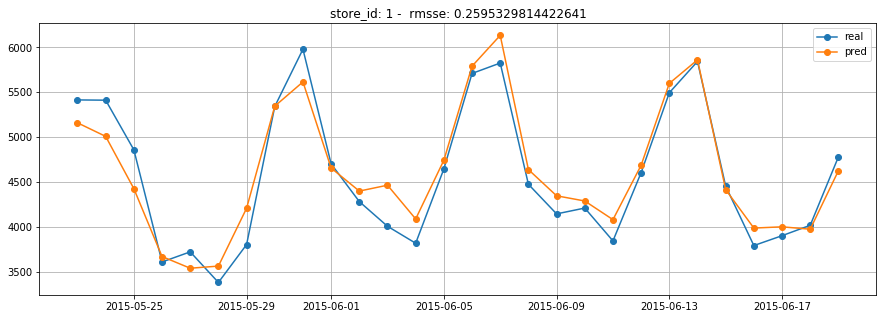

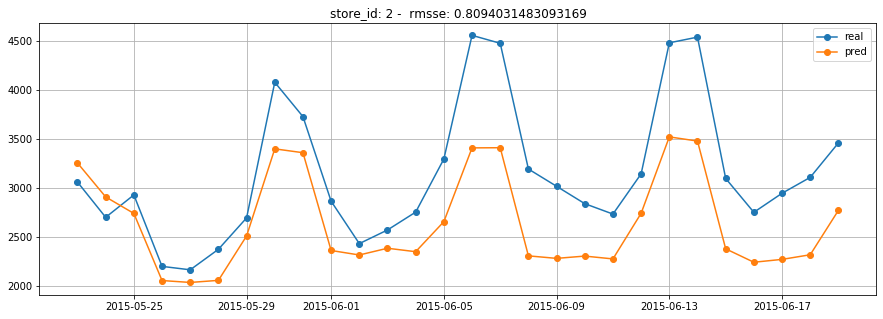

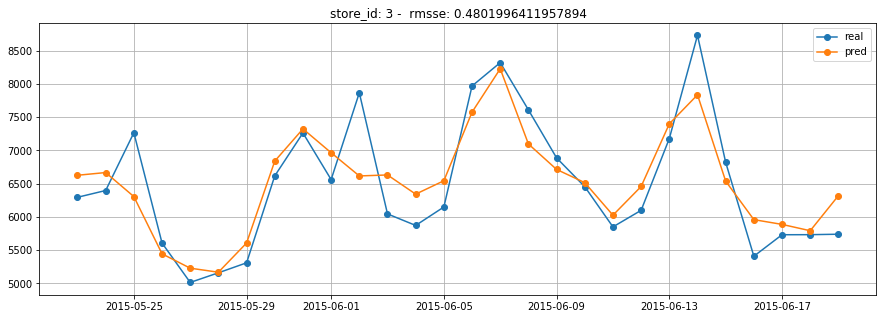

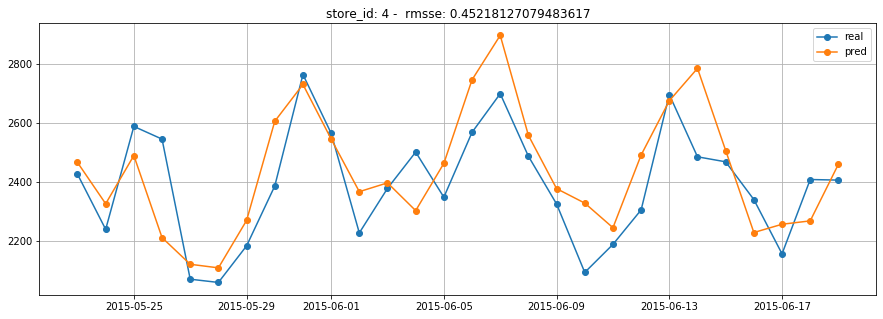

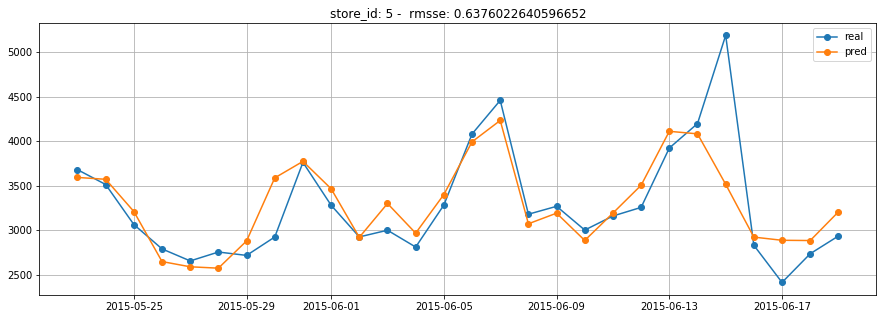

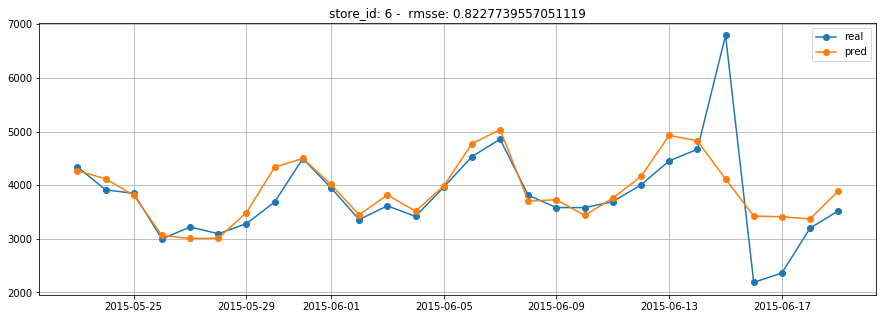

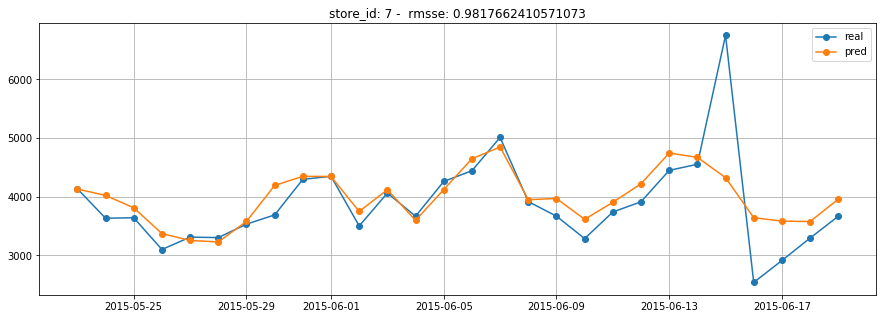

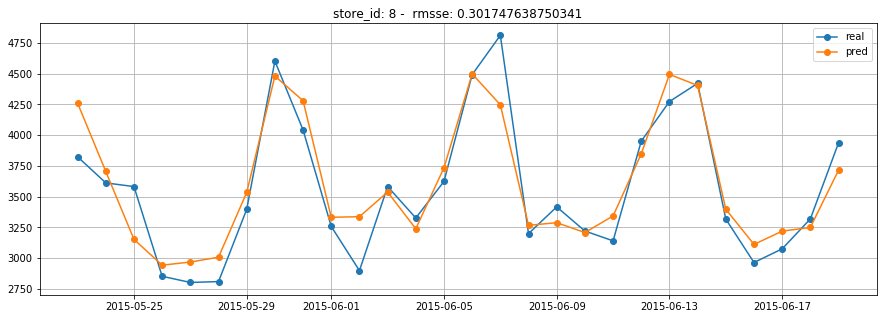

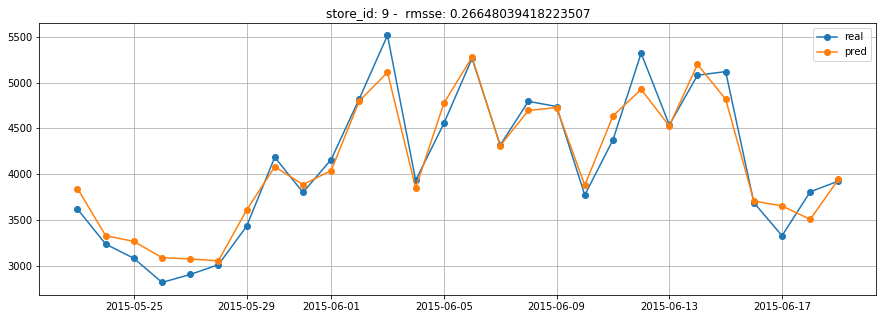

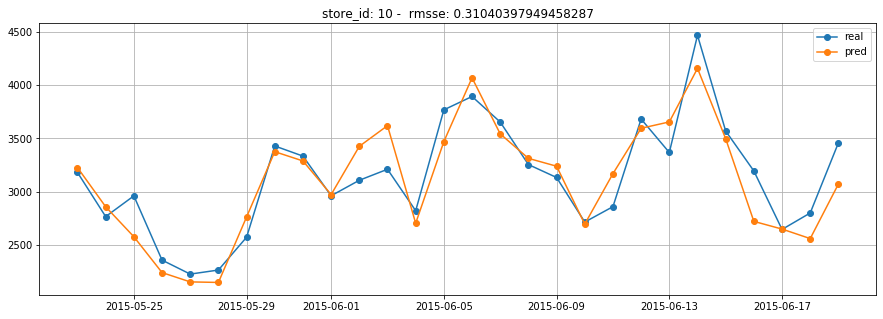

In [24]:
for store_id in range(1,11): 
    df_cut = mrg.query("store_id == @store_id")
    rmsse = np.sqrt(df_cut.eval("(y_raw-y_pred)**2").mean()) / scales_level3.query("store_id == @store_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"store_id: {store_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y_raw, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
# Level 12

In [25]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [26]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level12 = compute_scaling(scaling_input, agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

In [27]:
# outlier removal
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

In [28]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**11-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
                    #"n_prices",
                    #"price_iqr1",
                    #"price_iqr2",
                    #"price_min",
                    #"price_max",
                    #"price_momentum_q",
                    #"price_momentum_s",
                    "ts_id",
                    "event_type_1",
                    "event_name_2",
                    "event_type_2"]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "lags": list(range(1,15)),
    "window_shifts":[1,7,28],
    "window_functions":["mean","std"],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

In [29]:
# 5 years of history
train_history = 1825

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.755569	valid_0's wrmsse: 0.940659
[50]	valid_0's wrmsseL12: 0.696864	valid_0's wrmsse: 0.663717
[75]	valid_0's wrmsseL12: 0.688732	valid_0's wrmsse: 0.616442
[100]	valid_0's wrmsseL12: 0.686134	valid_0's wrmsse: 0.592384
[125]	valid_0's wrmsseL12: 0.686185	valid_0's wrmsse: 0.585434
[150]	valid_0's wrmsseL12: 0.686144	valid_0's wrmsse: 0.580477
[175]	valid_0's wrmsseL12: 0.685582	valid_0's wrmsse: 0.575834
[200]	valid_0's wrmsseL12: 0.685106	valid_0's wrmsse: 0.570582
[225]	valid_0's wrmsseL12: 0.684656	valid_0's wrmsse: 0.567455
[250]	valid_0's wrmsseL12: 0.684327	valid_0's wrmsse: 0.56657
[275]	val

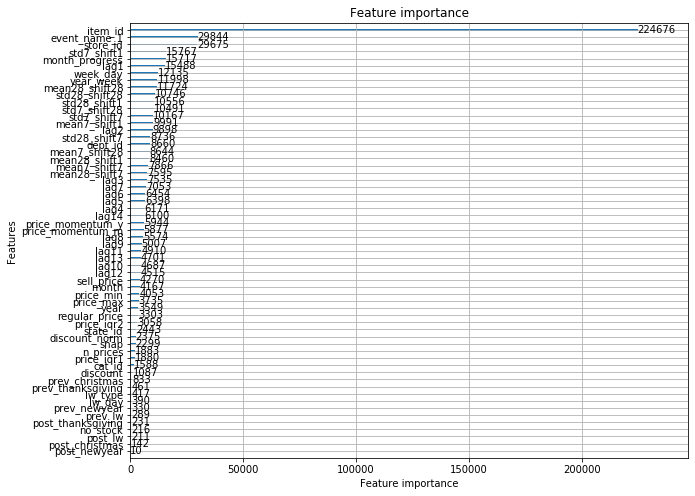

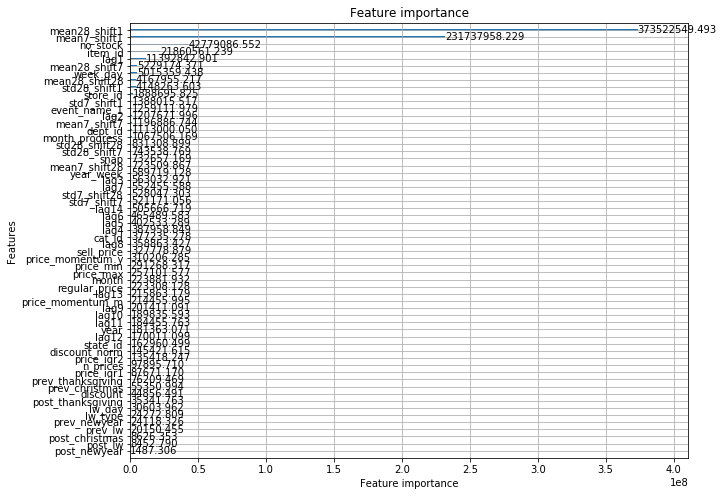

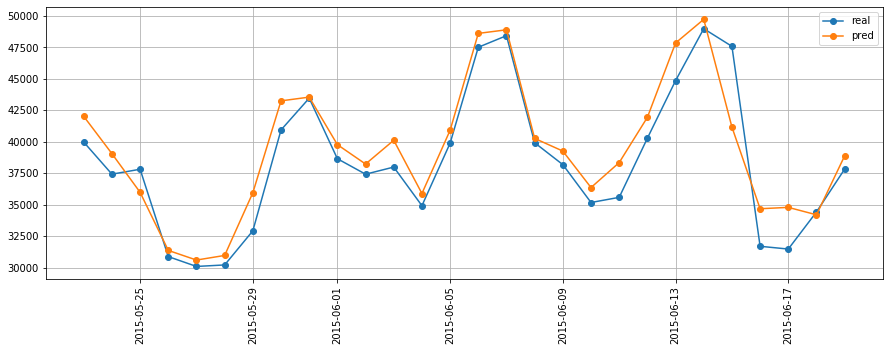

CPU times: user 10h 18min 32s, sys: 1h 28min 34s, total: 11h 47min 7s
Wall time: 2h 27min 54s


In [30]:
%%time

## VALIDATION MODEL

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
train_start = valid_start - pd.DateOffset(days=train_history)
_train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
_valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
model_level12.train_features.dropna(inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)

# needed to remove leakage of 'no_stock' feature
no_stock_ts = list()
for threshold in [28, 56, 84, 112, 140, 168]:
    left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
    no_stock_ts.append((model_level12.train_features
                        .query("ds >= @left_date")
                        .groupby(["ts_id"])
                        .filter(lambda x: np.all(x.y==0))
                        .loc[:, ["ts_id"]]
                        .drop_duplicates()))
model_level12.valid_features["no_stock"] = 0
for j,no_stock in enumerate(no_stock_ts):
    idx = model_level12.valid_features.query("ts_id in @no_stock.ts_id").index
    model_level12.valid_features.loc[idx, "no_stock"] = j+1

evaluator = Evaluator(model_level12.valid_features)
model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

# visualizing the predictions at level 1
predictions = (model_level12.valid_features
               .loc[:, ["ds"]+model_level12.ts_uid_columns]
               .assign(y_pred = model_level12.model.predict(model_level12.valid_features))
              )
mrg =  (data.loc[:, ["ds","item_id","store_id","y"]]
        .merge(predictions, how="inner", on=["ds","item_id","store_id"]))
df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()

print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

In [31]:
del model_level12, _train_data, evaluator
gc.collect()

28684

***

In [32]:
model_kwargs["model_params"]["num_iterations"] = 800
model_kwargs["model_params"]

{'objective': 'tweedie',
 'tweedie_variance_power': 1.1,
 'metric': 'None',
 'num_iterations': 800,
 'early_stopping_rounds': 300,
 'max_bin': 127,
 'bin_construct_sample_cnt': 6000000,
 'num_leaves': 1023,
 'min_data_in_leaf': 2047,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.66,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'seed': 7,
 'boost_from_average': False,
 'first_metric_only': True}

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
CPU times: user 6h 19min 36s, sys: 30min 1s, total: 6h 49min 37s
Wall time: 1h 1min 46s


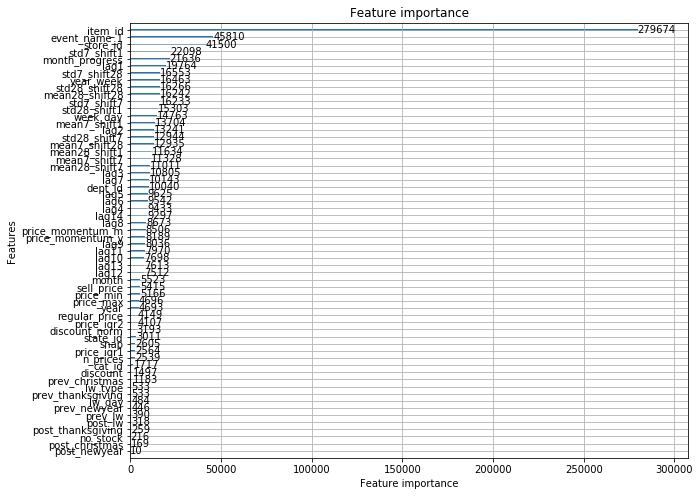

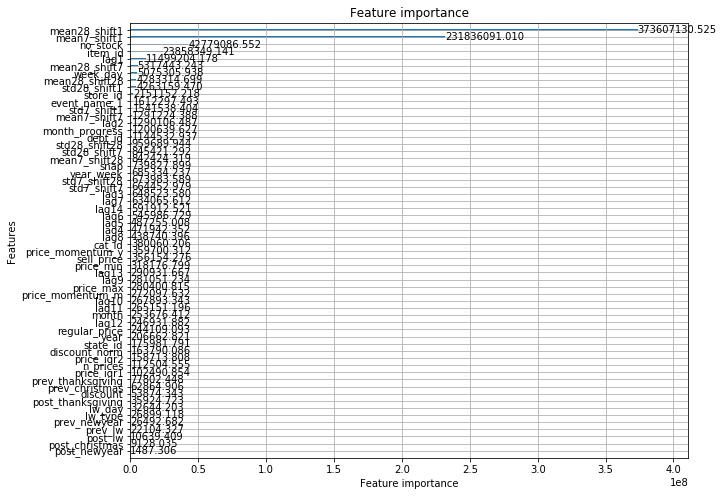

In [33]:
%%time

### REAL MODEL
print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
train_start = valid_start - pd.DateOffset(days=train_history)
_train_data = data.query("@train_start <= ds < @valid_start").reset_index(drop=True)

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data);
model_level12.train_features.dropna(inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.fit()

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

In [34]:
valid_data = data.query("@valid_period[0] <= ds <= @valid_period[1]").copy()
valid_data.drop("y", axis=1, inplace=True)

# needed to remove leakage of 'no_stock' feature
no_stock_ts = list()
for threshold in [28, 56, 84, 112, 140, 168]:
    left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
    no_stock_ts.append((model_level12.train_features
                        .query("ds >= @left_date")
                        .groupby(["ts_id"])
                        .filter(lambda x: np.all(x.y==0))
                        .loc[:, ["ts_id"]]
                        .drop_duplicates()))
    
valid_data["no_stock"] = 0
for j,no_stock in enumerate(no_stock_ts):
    idx = valid_data.query("ts_id in @no_stock.ts_id").index
    valid_data.loc[idx, "no_stock"] = j+1
    
# removes ts_id without training data
ts_id_in_train = set(model_level12.train_features.ts_id)
valid_data = valid_data.query("ts_id in @ts_id_in_train")

In [35]:
%%time
forecast_level12 = model_level12.predict(valid_data, recursive=True)

CPU times: user 1h 31min 41s, sys: 3min 40s, total: 1h 35min 22s
Wall time: 1h 21min 1s


***

In [44]:
valid_data = data.query("@valid_period[0] <= ds <= @valid_period[1]").copy()
valid_data = valid_data.query("ts_id in @ts_id_in_train")
valid_dataframe = valid_data.loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
evaluator = WRMSSEEvaluator(valid_dataframe)

In [45]:
evaluator._evaluate(valid_dataframe.merge(forecast_level12, how="left", on=["ds","item_id","store_id"]).y_pred.values)

0.6609215684012782

In [46]:
evaluator.errors_by_level

[0.5264471166817278,
 0.564250992467981,
 0.6625558568590235,
 0.5811258931873372,
 0.6178680832764328,
 0.6086857702276336,
 0.6593762419963399,
 0.6995786349897887,
 0.7354319007345392,
 0.7974393156784265,
 0.7596343807478253,
 0.7186646339682834]

In [47]:
mrg = pd.merge(forecast_level12,
               data.query("@valid_period[0] <= ds <= @valid_period[1]").loc[:, ["ds","item_id","store_id","y"]],
               how="inner", on=["ds","item_id","store_id"])

In [48]:
mrg["sq_error"] = mrg.eval("(y-y_pred)**2")

rmsse = (mrg
         .groupby(["store_id","item_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level12, how="left", on=["store_id","item_id"])
         .merge(weights_level12, how="left", on=["store_id","item_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse L12:", rmsse)

rmsse L12: 0.7186646339682834


***
#### Error of level 12 predictions at level 1

RMSE: 3119.7323056691816
RMSSE: 0.5264471177507233


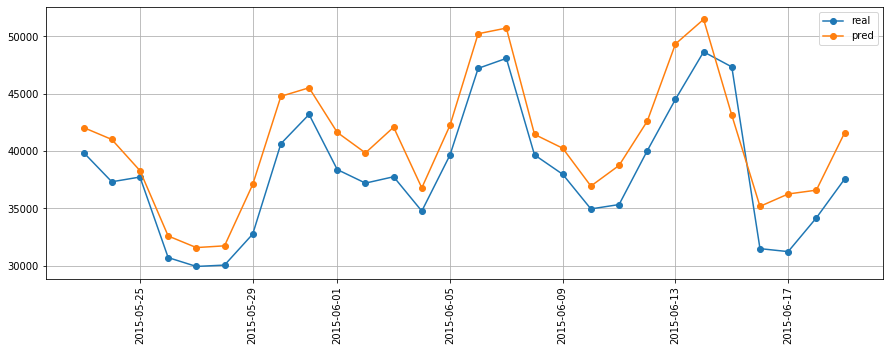

In [49]:
df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()

print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

***
#### Error of level 12 predictions at level 2

In [50]:
org = data.loc[:, ["store_id","state_id"]].drop_duplicates()

In [51]:
df = (mrg
      .merge(org, how="left")
      .groupby(["ds","state_id"])["y","y_pred"]
      .sum()
      .reset_index())

In [52]:
df["sq_error"] = df.eval("(y-y_pred)**2")

rmsse = (df
         .groupby(["state_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level2, how="left", on=["state_id"])
         .merge(weights_level2, how="left", on=["state_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.564250992467981


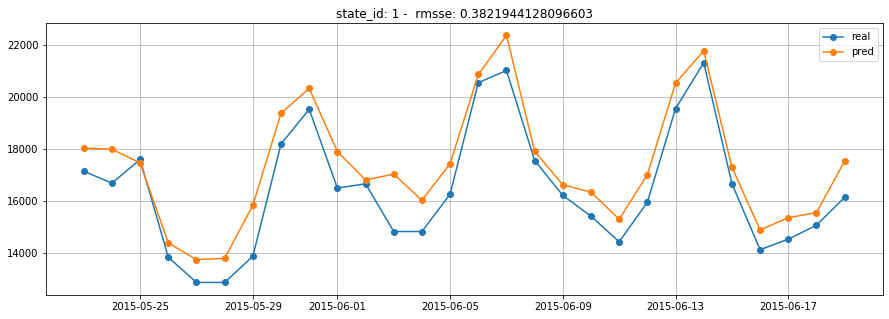

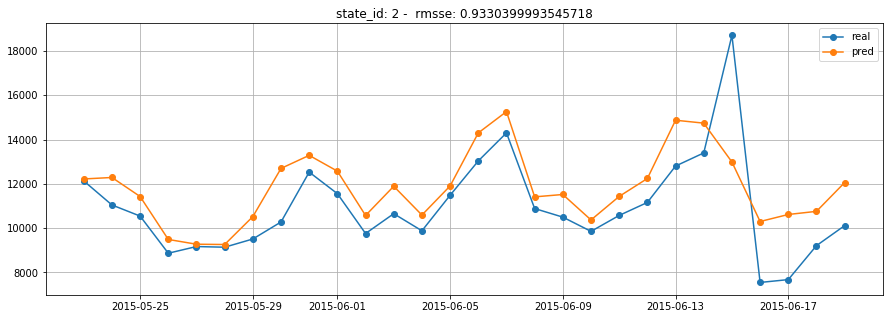

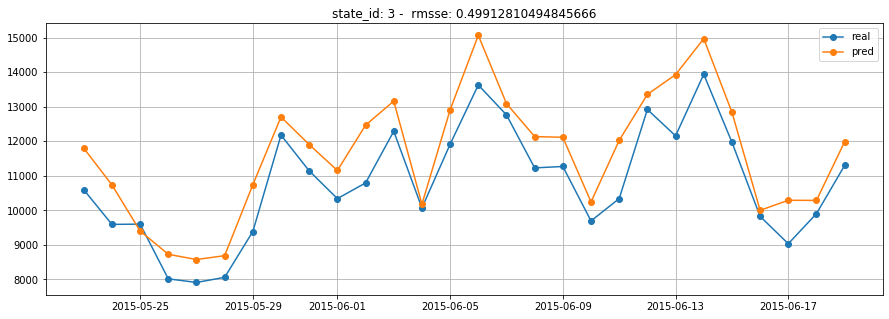

In [53]:
for state_id in [1,2,3]:    
    df_cut = df.query("state_id == @state_id")
    rmsse = np.sqrt(df_cut.eval("(y-y_pred)**2").mean()) / scales_level2.query("state_id == @state_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"state_id: {state_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
#### Error of level 12 predictions at level 3

In [54]:
df = (mrg
      .groupby(["ds","store_id"])["y","y_pred"]
      .sum()
      .reset_index())

In [55]:
df["sq_error"] = df.eval("(y-y_pred)**2")

rmsse = (df
         .groupby(["store_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level3, how="left", on=["store_id"])
         .merge(weights_level3, how="left", on=["store_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.6625558568590235


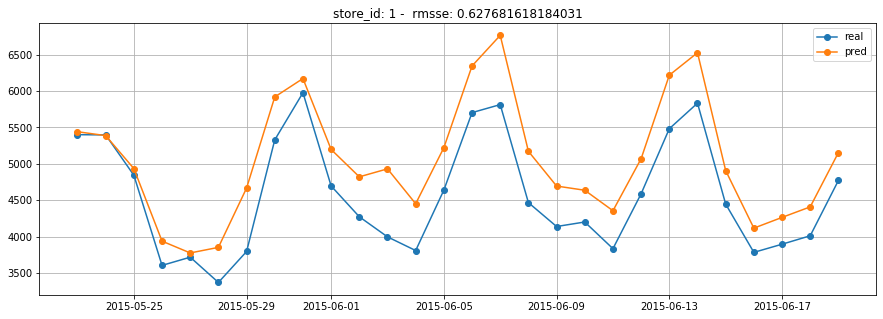

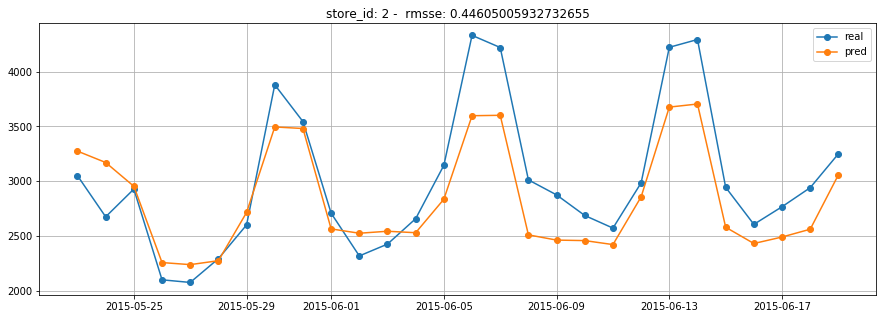

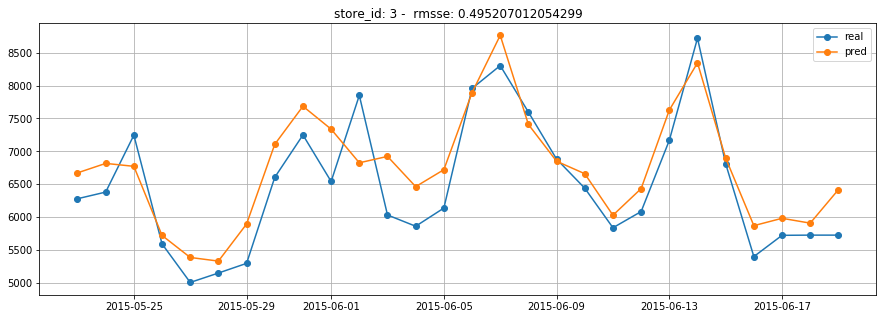

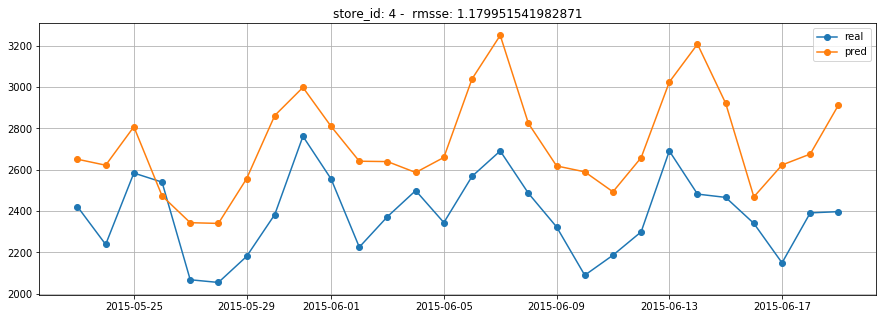

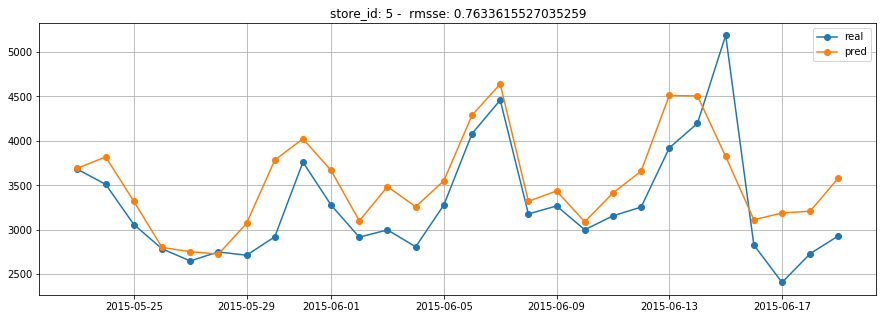

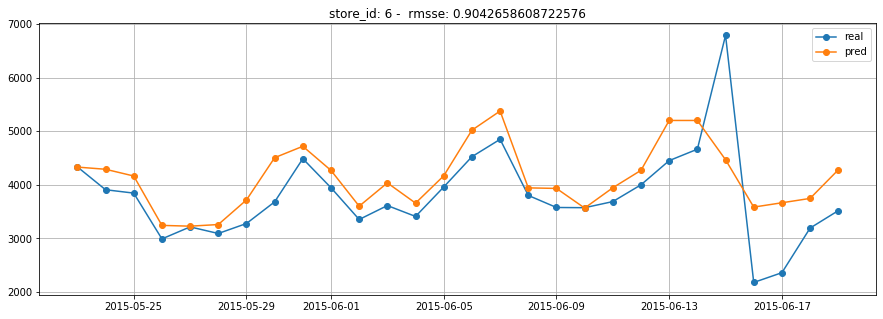

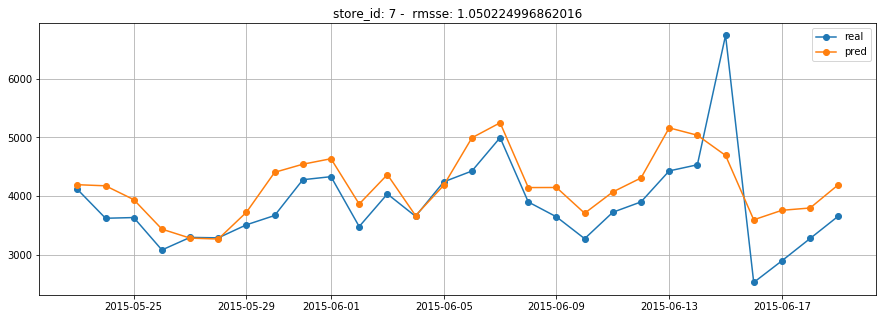

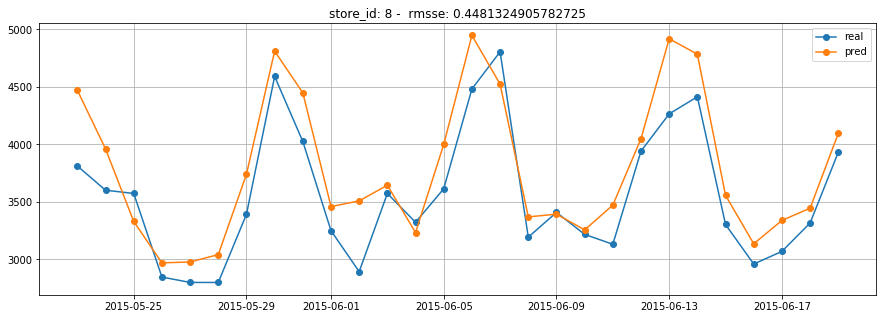

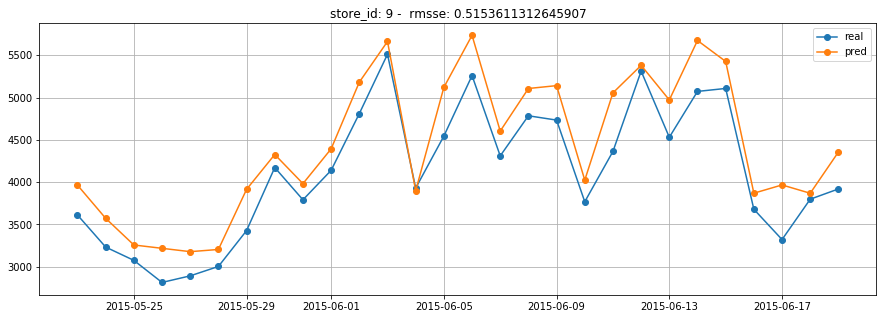

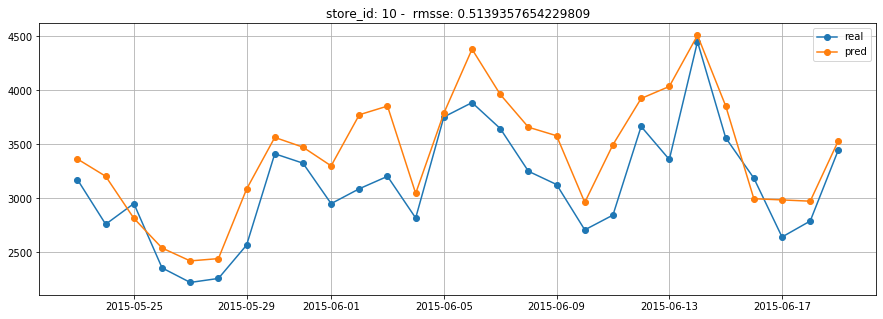

In [56]:
for store_id in range(1,11): 
    df_cut = df.query("store_id == @store_id")
    rmsse = np.sqrt(df_cut.eval("(y-y_pred)**2").mean()) / scales_level3.query("store_id == @store_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"store_id: {store_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***
### storing the resulting forecast

In [57]:
#forecast_level1.to_csv("../output/forecast_level1_hts.csv", index=False)
#forecast_level2.to_csv("../output/forecast_level2_hts.csv", index=False)
#forecast_level3.to_csv("../output/forecast_level3_hts.csv", index=False)
#forecast_level12.to_csv("../output/forecast_level12_hts.csv", index=False)

***
# HTS distribution

In [58]:
import pickle
from mahts import HTSDistributor

In [59]:
hierarchy = pd.read_parquet("../input/hierarchy_raw.parquet")

infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

***

In [60]:
fcst_l01 = (
    forecast_level1
    .set_index("ds")
    .rename({"y_pred":"root"}, axis=1)
)
fcst_l01.head()

,root
ds,
2015-05-23,41012.109264
2015-05-24,38236.401287
2015-05-25,35516.611840
2015-05-26,30993.143016
2015-05-27,30243.073482


In [61]:
fcst_l02 = (
    forecast_level2
    .assign(state_id = lambda x: encoders["state"].inverse_transform(x.state_id))
    .pivot(index="ds", columns="state_id", values="y_pred")
)
fcst_l02.head()

state_id,CA,TX,WI
ds,,,
2015-05-23,17582.638084,12221.610645,11389.498713
2015-05-24,16909.491444,11714.504024,9757.019171
2015-05-25,16018.189915,10935.020349,8845.977269
2015-05-26,13552.176143,9240.877696,8377.263390
2015-05-27,13083.085291,8954.644470,8281.995144


In [62]:
fcst_l03 = (
    forecast_level3
    .assign(store_id = lambda x: encoders["store"].inverse_transform(x.store_id))
    .pivot(index="ds", columns="store_id", values="y_pred")
)
fcst_l03.head()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
ds,,,,,,,,,,
2015-05-23,5159.953903,3255.597212,6625.094276,2466.813652,3592.663212,4269.040350,4131.848377,4259.767706,3840.689060,3226.464697
2015-05-24,5008.525754,2909.652689,6665.762325,2326.821788,3571.591498,4118.710241,4023.545217,3704.702955,3326.373762,2860.072491
2015-05-25,4426.133738,2741.598086,6304.762350,2490.263321,3209.616498,3810.624992,3812.898285,3152.875025,3263.616489,2579.728526
2015-05-26,3669.855279,2057.697383,5444.277260,2212.063644,2646.705910,3061.608304,3373.731155,2943.394032,3086.243111,2244.262332
2015-05-27,3539.417584,2038.285071,5228.302802,2121.613643,2587.972875,3006.343516,3256.091597,2968.855525,3071.652120,2157.092553


In [63]:
fcst_l12 = (
    forecast_level12
    .assign(item_id = lambda x: encoders["item"].inverse_transform(x.item_id))
    .assign(store_id = lambda x: encoders["store"].inverse_transform(x.store_id))
    .merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left", on=["item_id","store_id"])
    .drop(["item_id","store_id"], axis=1)
    .pivot(index="ds", columns="id", values="y_pred")
)
fcst_l12.head()

id,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,FOODS_1_001_WI_3,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2015-05-23,0.997320,0.741723,0.968967,0.318320,0.642986,0.531755,0.793914,0.540838,0.432530,0.210686,...,0.320920,0.253000,0.360459,0.135936,0.000262,0.393197,0.359253,0.151588,0.123173,0.122863
2015-05-24,0.849272,0.614878,0.788427,0.297119,0.537911,0.500371,0.688726,0.390868,0.292486,0.193576,...,0.291146,0.228630,0.329228,0.127481,0.000265,0.397978,0.316899,0.137765,0.102930,0.112175
2015-05-25,0.596349,0.339521,0.584822,0.188360,0.274579,0.343814,0.523409,0.260954,0.187635,0.104051,...,0.254064,0.182192,0.315855,0.126486,0.000286,0.385818,0.266989,0.104758,0.090526,0.091407
2015-05-26,0.608196,0.434485,0.843063,0.253335,0.341987,0.370048,0.617386,0.360519,0.287007,0.201917,...,0.188268,0.146893,0.233312,0.116170,0.000275,0.299803,0.217647,0.097931,0.096079,0.089424
2015-05-27,0.608591,0.398523,0.840487,0.298529,0.373990,0.397901,0.644893,0.355540,0.301494,0.179247,...,0.189647,0.146554,0.214972,0.122494,0.000284,0.344148,0.222752,0.100734,0.102142,0.100383


In [64]:
hierarchy_dict = {"root":fcst_l12.columns}

#hierarchy_dict = {"root":hierarchy.state_id.unique()}

#for state_id in hierarchy.state_id.unique():
#    hierarchy_dict[state_id] = hierarchy.query("state_id == @state_id").store_id.unique()
    
#for store_id in hierarchy.store_id.unique():
#    hierarchy_dict[store_id] = hierarchy.query("store_id == @store_id & id in @fcst_l12.columns").id.unique()

In [65]:
%%time
hts = HTSDistributor(hierarchy_dict)

CPU times: user 4min 7s, sys: 26.8 s, total: 4min 34s
Wall time: 4min 34s


In [66]:
#fcst_all_levels = pd.concat([fcst_l01, fcst_l02, fcst_l03, fcst_l12], axis=1)
fcst_all_levels = pd.concat([fcst_l01, fcst_l12], axis=1)
fcst_all_levels.head()

,root,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2015-05-23,41012.109264,0.997320,0.741723,0.968967,0.318320,0.642986,0.531755,0.793914,0.540838,0.432530,...,0.320920,0.253000,0.360459,0.135936,0.000262,0.393197,0.359253,0.151588,0.123173,0.122863
2015-05-24,38236.401287,0.849272,0.614878,0.788427,0.297119,0.537911,0.500371,0.688726,0.390868,0.292486,...,0.291146,0.228630,0.329228,0.127481,0.000265,0.397978,0.316899,0.137765,0.102930,0.112175
2015-05-25,35516.611840,0.596349,0.339521,0.584822,0.188360,0.274579,0.343814,0.523409,0.260954,0.187635,...,0.254064,0.182192,0.315855,0.126486,0.000286,0.385818,0.266989,0.104758,0.090526,0.091407
2015-05-26,30993.143016,0.608196,0.434485,0.843063,0.253335,0.341987,0.370048,0.617386,0.360519,0.287007,...,0.188268,0.146893,0.233312,0.116170,0.000275,0.299803,0.217647,0.097931,0.096079,0.089424
2015-05-27,30243.073482,0.608591,0.398523,0.840487,0.298529,0.373990,0.397901,0.644893,0.355540,0.301494,...,0.189647,0.146554,0.214972,0.122494,0.000284,0.344148,0.222752,0.100734,0.102142,0.100383


In [67]:
fcst_reconc = hts.compute_optimal_combination(fcst_all_levels, 
                                              backend="lsmr",
                                              solver_kwargs={"atol":1e-8,
                                                             "btol":1e-8,
                                                             "maxiter":1e6})
fcst_reconc.set_index(fcst_all_levels.index, inplace=True)

----------------------------------------------------------------------------------------------------
---------------------------- Reconciling time step: 2015-05-23 00:00:00 ----------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 3
r1norm norm(r): 6.029880057488978
Ar-norm: 1.0415778461093426e-13
A-norm: 244.82851141155786
A-cond: 173.11845655501742
x-norm: 575.3067628403979
----------------------------------------------------------------------------------------------------
---------------------------- Reconciling time step: 2015-05-24 00:00:00 ----------------------------
----------------------------------------------------------------------------------------------------
stop: 2. x approximately solves the least-squares problem according to atol.
n-iterations: 3
r1norm norm(r): 16.06857115835166
Ar-norm: 1.0057338343433226e

***

In [310]:
forecast = fcst_all_levels.head(1)

In [311]:
X = hts.sparse_summing_matrix

In [312]:
y = forecast.loc[:, hts.tree_nodes].values

In [315]:
#beta = forecast.loc[:, hts.bottom_nodes].values.ravel()
beta = fcst_reconc.head(1).loc[:, hts.bottom_nodes].values.ravel()

In [316]:
np.linalg.norm(X.dot(beta) - y)

80.81330148948861

***

In [68]:
fcst_all_levels.head()

,root,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2015-05-23,41012.109264,0.997320,0.741723,0.968967,0.318320,0.642986,0.531755,0.793914,0.540838,0.432530,...,0.320920,0.253000,0.360459,0.135936,0.000262,0.393197,0.359253,0.151588,0.123173,0.122863
2015-05-24,38236.401287,0.849272,0.614878,0.788427,0.297119,0.537911,0.500371,0.688726,0.390868,0.292486,...,0.291146,0.228630,0.329228,0.127481,0.000265,0.397978,0.316899,0.137765,0.102930,0.112175
2015-05-25,35516.611840,0.596349,0.339521,0.584822,0.188360,0.274579,0.343814,0.523409,0.260954,0.187635,...,0.254064,0.182192,0.315855,0.126486,0.000286,0.385818,0.266989,0.104758,0.090526,0.091407
2015-05-26,30993.143016,0.608196,0.434485,0.843063,0.253335,0.341987,0.370048,0.617386,0.360519,0.287007,...,0.188268,0.146893,0.233312,0.116170,0.000275,0.299803,0.217647,0.097931,0.096079,0.089424
2015-05-27,30243.073482,0.608591,0.398523,0.840487,0.298529,0.373990,0.397901,0.644893,0.355540,0.301494,...,0.189647,0.146554,0.214972,0.122494,0.000284,0.344148,0.222752,0.100734,0.102142,0.100383


In [69]:
fcst_reconc.head()

,root,FOODS_1_001_CA_1,FOODS_1_001_CA_2,FOODS_1_001_CA_3,FOODS_1_001_CA_4,FOODS_1_001_TX_1,FOODS_1_001_TX_2,FOODS_1_001_TX_3,FOODS_1_001_WI_1,FOODS_1_001_WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2015-05-23,41012.144094,0.962489,0.706892,0.934136,0.283489,0.608155,0.496924,0.759083,0.506008,0.397699,...,0.286089,0.218169,0.325628,0.101105,-0.034569,0.358366,0.324422,0.116757,0.088342,0.088032
2015-05-24,38236.494105,0.756454,0.522059,0.695608,0.204301,0.445092,0.407553,0.595908,0.298050,0.199667,...,0.198327,0.135812,0.236410,0.034663,-0.092553,0.305160,0.224080,0.044947,0.010112,0.019357
2015-05-25,35516.704579,0.503610,0.246782,0.492083,0.095621,0.181840,0.251075,0.430670,0.168215,0.094896,...,0.161325,0.089453,0.223116,0.033747,-0.092453,0.293079,0.174250,0.012019,-0.002213,-0.001332
2015-05-26,30993.196733,0.554479,0.380767,0.789346,0.199617,0.288270,0.316331,0.563668,0.306802,0.233289,...,0.134551,0.093176,0.179595,0.062453,-0.053443,0.246086,0.163930,0.044214,0.042362,0.035706
2015-05-27,30243.118462,0.563611,0.353543,0.795507,0.253549,0.329010,0.352921,0.599913,0.310560,0.256514,...,0.144666,0.101574,0.169992,0.077513,-0.044696,0.299168,0.177772,0.055754,0.057162,0.055403


In [70]:
forecast_level12_reconc = (fcst_reconc
 .loc[:, hts.bottom_nodes]
 .reset_index()
 .melt(id_vars="ds", value_vars=hts.bottom_nodes, var_name="id", value_name="y_pred")
 .merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left")
 .drop(["id"], axis=1)
 .assign(item_id = lambda x: encoders["item"].transform(x.item_id))
 .assign(store_id = lambda x: encoders["store"].transform(x.store_id))
)
forecast_level12_reconc.head()

,ds,y_pred,item_id,store_id
0,2015-05-23,0.962489,1613,1
1,2015-05-24,0.756454,1613,1
2,2015-05-25,0.503610,1613,1
3,2015-05-26,0.554479,1613,1
4,2015-05-27,0.563611,1613,1


In [71]:
# diff with previous bottom forecast
_mrg = pd.merge(forecast_level12, forecast_level12_reconc, how="inner", on=["ds","item_id","store_id"])
np.sqrt(_mrg.eval("(y_pred_x - y_pred_y)**2").mean())

0.09254668817962608

In [72]:
_mrg["difference"] = _mrg.y_pred_x - _mrg.y_pred_y

In [73]:
_mrg.groupby("ds")["difference"].mean().reset_index()

,ds,difference
0,2015-05-23,0.034831
1,2015-05-24,0.092818
2,2015-05-25,0.092739
3,2015-05-26,0.053717
4,2015-05-27,0.044980
5,2015-05-28,0.051454
6,2015-05-29,0.082169
7,2015-05-30,0.080684
8,2015-05-31,0.085799
9,2015-06-01,0.084879


In [74]:
pd.merge(forecast_level12.groupby(["ds"])["y_pred"].sum(), fcst_reconc.loc[:, ["root"]], on="ds")

,y_pred,root
ds,,
2015-05-23,42055.992792,41012.144094
2015-05-24,41018.167525,38236.494105
2015-05-25,38295.999568,35516.704579
2015-05-26,32603.051654,30993.196733
2015-05-27,31591.132492,30243.118462
2015-05-28,31742.777609,30200.739575
2015-05-29,37092.572167,34630.038352
2015-05-30,44780.036995,42362.027149
2015-05-31,45525.061210,42953.746452


***

In [75]:
evaluator._evaluate(valid_dataframe.merge(forecast_level12_reconc, how="left", on=["ds","item_id","store_id"]).y_pred.values)

0.5495499726061159

In [76]:
evaluator.errors_by_level

[0.33368369330403125,
 0.4081554310048168,
 0.5255785695495399,
 0.3838770884831364,
 0.43040587714462686,
 0.46266240149979543,
 0.5357779690618664,
 0.5868369726600439,
 0.6450960084124068,
 0.8005242446708183,
 0.7614029571280284,
 0.7205984583542815]

***

In [77]:
mrg = pd.merge(forecast_level12_reconc,
               data.query("@valid_period[0] <= ds <= @valid_period[1]").loc[:, ["ds","item_id","store_id","y"]],
               how="inner", on=["ds","item_id","store_id"])
mrg["sq_error"] = mrg.eval("(y-y_pred)**2")

In [78]:
rmsse = (mrg
         .groupby(["store_id","item_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level12, how="left", on=["store_id","item_id"])
         .merge(weights_level12, how="left", on=["store_id","item_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse L12:", rmsse)

rmsse L12: 0.7205984583542816


***
#### Error of level 12 predictions at level 1

RMSE: 1977.413808317883
RMSSE: 0.3336836939816013


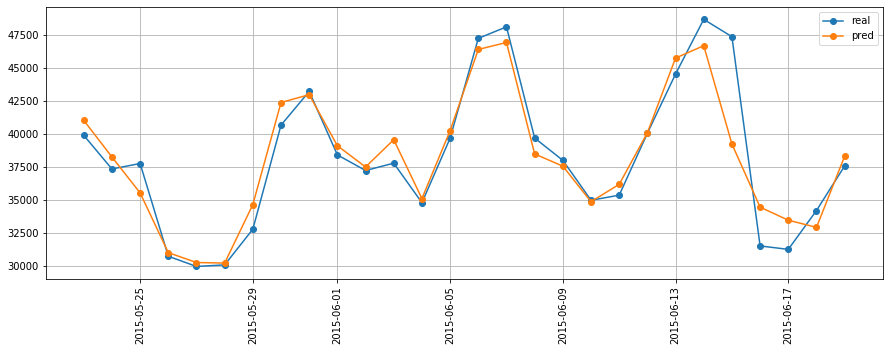

In [79]:
df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()

print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

***

In [82]:
org = data.loc[:, ["store_id","state_id"]].drop_duplicates()

In [83]:
df = (mrg
      .merge(org, how="left")
      .groupby(["ds","state_id"])["y","y_pred"]
      .sum()
      .reset_index())

In [84]:
df["sq_error"] = df.eval("(y-y_pred)**2")

rmsse = (df
         .groupby(["state_id"])["sq_error"]
         .mean()
         .reset_index(name="mse")
         .merge(scales_level2, how="left", on=["state_id"])
         .merge(weights_level2, how="left", on=["state_id"])
         .assign(weight = lambda x: x.weight/x.weight.sum())
         .eval("weight * (sqrt(mse)/s)")
         .sum()
        )
print("rmsse:", rmsse)

rmsse: 0.40815543100481605


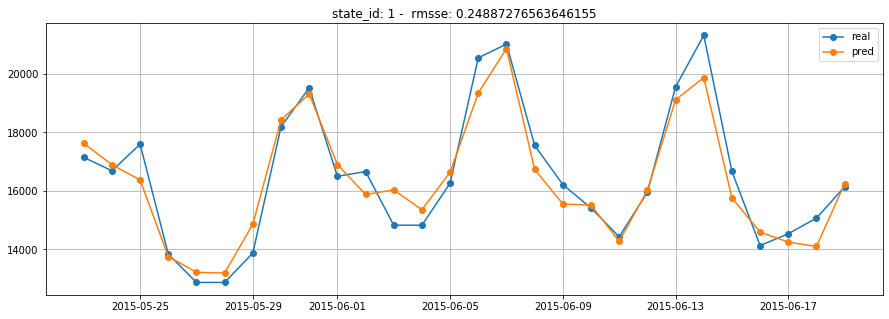

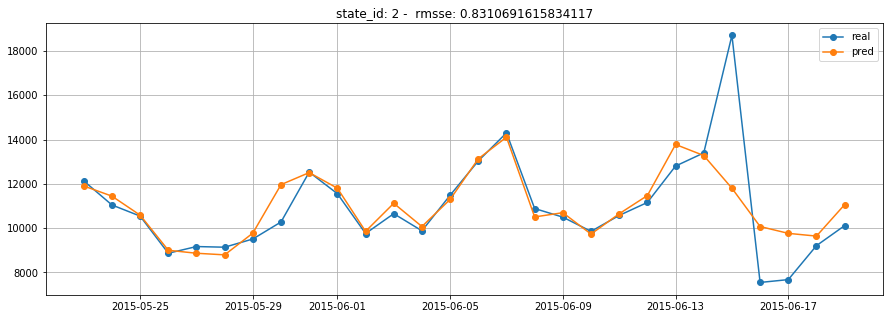

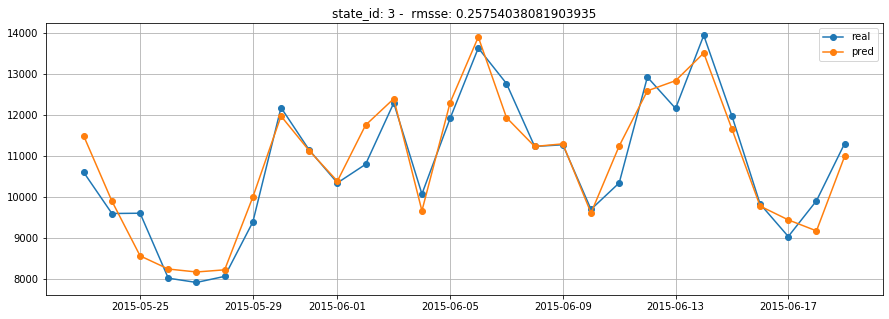

In [85]:
for state_id in [1,2,3]:    
    df_cut = df.query("state_id == @state_id")
    rmsse = np.sqrt(df_cut.eval("(y-y_pred)**2").mean()) / scales_level2.query("state_id == @state_id").s.values[0]
    plt.figure(figsize=(15,5))
    plt.title(f"state_id: {state_id} -  rmsse: {rmsse}")
    plt.plot_date(df_cut.ds, df_cut.y, "o-", label="real")
    plt.plot_date(df_cut.ds, df_cut.y_pred, "o-", label="pred")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

***